# Capstone 3 - Exploratory Data Analysis

### Table of contents
* [Introduction](#intro)
    * [Guiding questions & ideas](#guiding-questions)
    * [Import relevant packages](#import)
    * [Retrieve variables](#variables)
* [Noise data](#noise-data)
* [School demographic & achievement data](#demographic-data)
    * [Demographic summaries by academic year](#demographic-summaries)
    * [Lower grades achievement data by academic year](#lg-achievement)
    * [High school achievement data by academic year](#hs-achievement)
* [School noise coefficient of variation](#coefficient-variation)
    * [School noise-performance variation](#noise-performance)
* [Analysis of noise impact on academic achievement](#noise-achievement-impact)
    * [Noise-achievement correlations: Lower grades](#lg-correlations)
    * [Noise-achievement correlations: High school](#hs-correlations)

## Introduction <a name="intro"></a>

Despite ample evidence of causing mental and physical harm, the effects of environmental noise on educational outcomes is not well documented. This project aims to understand how environmental noise affects educational outcomes of elementary, middle, and high schoolers in New York City between the 2016-2017 and 2018-2019 school years.

This notebook for Exploratory Data Analysis picks up where we left off in section 1 - Cleaning & Wrangling.

### Guiding questions & ideas <a name="guiding-questions"></a>

Guiding questions as we complete our Exploratory Data Analysis include:
- Does increased noise exposure correlate with decreased academic performance?
- Can we predict a school's academic performance based on its noise exposure profile?
- How much variance in student achievement can be explained by environmental noise?
- Can we identify schools that are most vulnerable to noise impacts?
- Can we predict which schools will exceed/fall below performance targets based on noise exposure?
- Do certain types of noise (e.g., construction, traffic) have different impacts?
- Are there temporal patterns in noise impact (time of day, day of week, seasonal)?

### Import relevant packages <a name="import"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium import plugins
import branca.colormap as cm
from IPython.display import display, HTML

### Retrieve variables <a name="variables"></a>
Let's retrieve the variables we saved in our data cleaning & wrangling phase.

In [2]:
# Retrieve original noise_data dataframe
%store -r noise_data

# Retrieve GeoPandas dataframes
%store -r districts_gdf 
%store -r schoolpoints_gdf
%store -r sensors_gdf

# Retrieve schools covered by sensor range
%store -r coverage_matrix

# Retrieve school demographic information
%store -r combined_summary_df

# Retrieve lower grades achievement information
%store -r combined_lg_achievement_df

# Retrieve high school achievement information
%store -r combined_hs_achievement_df

# # Retrieve combined achievement data
# %store -r coverage_combined_achievement_df
# %store -r non_coverage_combined_achievement_df

# Retrieve school lists
%store -r elem_middle_schools
%store -r high_schools

# Retrieve school-sensor pairs
%store -r school_sensor_pairs

---

## Noise data <a name="noise-data"></a>

We will start by looking at patterns in our `noise_data` dataframe.

Later in this section, we will look at recording distribution per school to see whether there are any schools that we need to remove from our dataframes.

### Hourly recording data

In [3]:
# Create a dictionary for renaming the columns for simpler legend labels
simplified_labels = {
    '1_engine_presence': 'engine',
    '2_machinery-impact_presence': 'machinery',
    '3_non-machinery-impact_presence': 'non-machinery',
    '4_powered-saw_presence': 'powered saw',
    '5_alert-signal_presence': 'alert signal',
    '6_music_presence': 'music',
    '7_human-voice_presence': 'human voice',
    '8_dog_presence': 'dog'
}

# Get list of presence variables only
presence_cols = [col for col in noise_data.columns if col.endswith('_presence')]

# Rename columns for plotting
hourly_means = noise_data.groupby('hour')[presence_cols].mean().rename(columns=simplified_labels)

<Figure size 2500x1000 with 0 Axes>

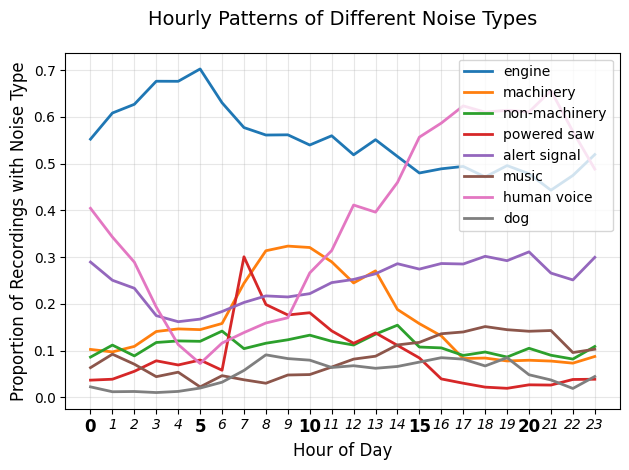

In [4]:
# Plot with adjusted legend
plt.figure(figsize=(25, 10))
hourly_means.plot(linewidth=2)

# Titles and labels
plt.title('Hourly Patterns of Different Noise Types', pad=20, size=14)
plt.xlabel('Hour of Day', size=12)
plt.ylabel('Proportion of Recordings with Noise Type', size=12)

# Grid and legend
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=10, framealpha=0.8)

# Customizing x-axis ticks
ticks = range(24)  # Hours from 0 to 23
plt.xticks(ticks=ticks)  # Set ticks

# Modify the appearance of tick labels
ax = plt.gca()
for tick in ax.get_xticklabels():
    hour = int(tick.get_text())
    if hour % 5 == 0:  # Larger for multiples of 5
        tick.set_fontsize(12)
        tick.set_fontweight('bold')
    else:  # Smaller for all other hours
        tick.set_fontsize(10)
        tick.set_fontstyle('italic')

# Save the figure to a file
plt.savefig("./Figures/hourly_patterns.png", dpi=300, bbox_inches='tight')
        
# Layout adjustments and show
plt.tight_layout()
plt.show()

This lineplot reveals interesting noise patterns throughout the day:
- Perhaps unsurprisingly due to New York's heavy car traffic, engines are the most common sound and peak in activity around 5am, near morning rush hour.
- Human voice activity has the widest variation of all sounds. Activity is lowest around 5am and highest around 9pm.
- Powered saws have a sharp spike in activity at 7am and gradually decrease throughout the day from there, with the least activity happening around 7pm.
- Machinery sounds are active throughout the school day, peaking in activity around 10am.
- Music is relatively infrequent, but sees a dip in activity during the morning hours, with most music being played between 4pm and 9pm.

### Weekly recording data

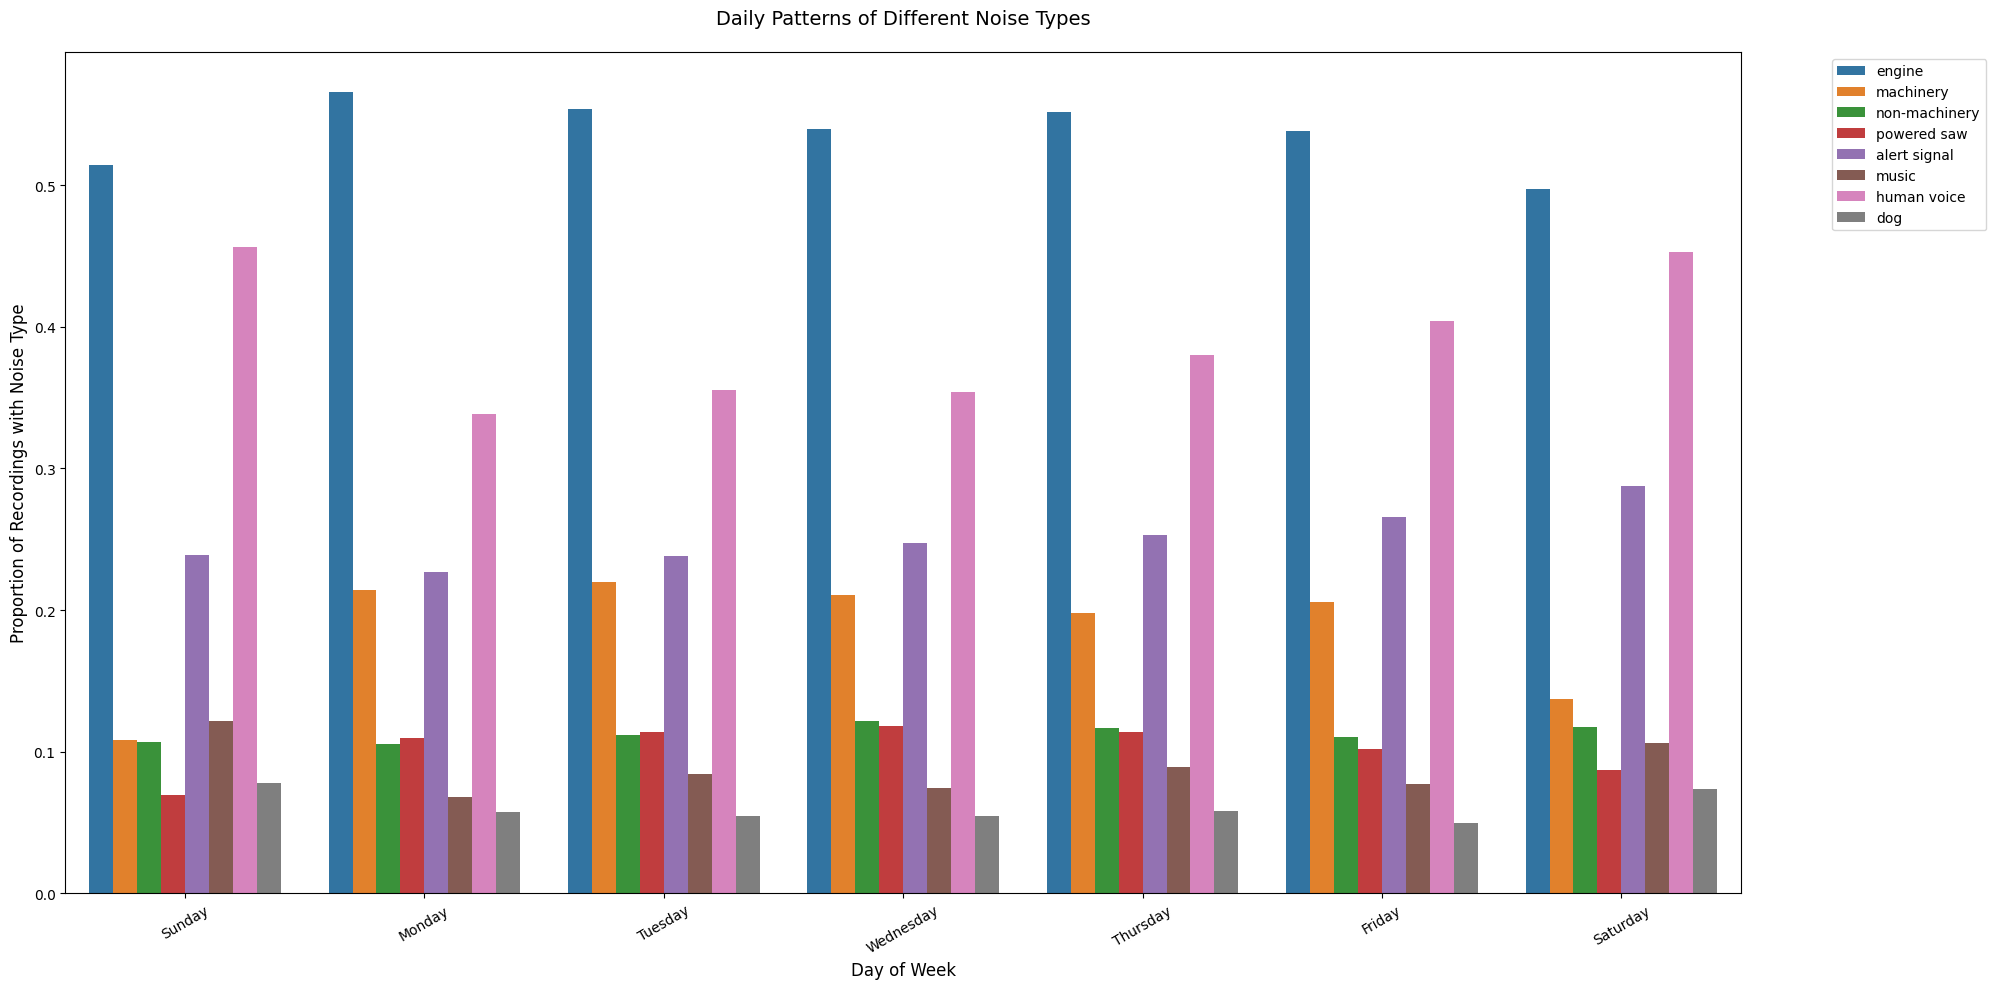

In [5]:
# Create day of week patterns
plt.figure(figsize=(20, 10))
day_map = {6: 'Sunday', 0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 
           3: 'Thursday', 4: 'Friday', 5: 'Saturday'}
daily_means = noise_data.groupby('day')[presence_cols].mean().rename(columns=simplified_labels)
daily_means = daily_means.reindex([6, 0, 1, 2, 3, 4, 5])
daily_means.index = [day_map[x] for x in daily_means.index]

# Using seaborn's barplot for better spacing and appearance
plot_data = daily_means.reset_index().melt(id_vars='index')
sns.barplot(data=plot_data, x='index', y='value', hue='variable')
plt.title('Daily Patterns of Different Noise Types', pad=20, size=14)
plt.xlabel('Day of Week', size=12)
plt.ylabel('Proportion of Recordings with Noise Type', size=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(rotation=30)

# Save the figure to a file
plt.savefig("./Figures/weekly_patterns.png", dpi=300, bbox_inches='tight')

# Layout adjustments and show
plt.tight_layout()
plt.show()

Some observations on weekly noise activity:
- Engine sounds remain relatively constant throughout the week, but see a slight decline in activity on Saturday and Sunday.
- Human voices are most recorded on Friday, Saturday, and Sunday.
- Music is recorded most on Saturday and Sunday.
- Machinery is highly active from Monday through Friday compared to Saturday and Sunday.
- Likewise, powered saws are heard most often Monday through Friday and see a decline in activity on Saturday and Sunday.

### Monthly recording data

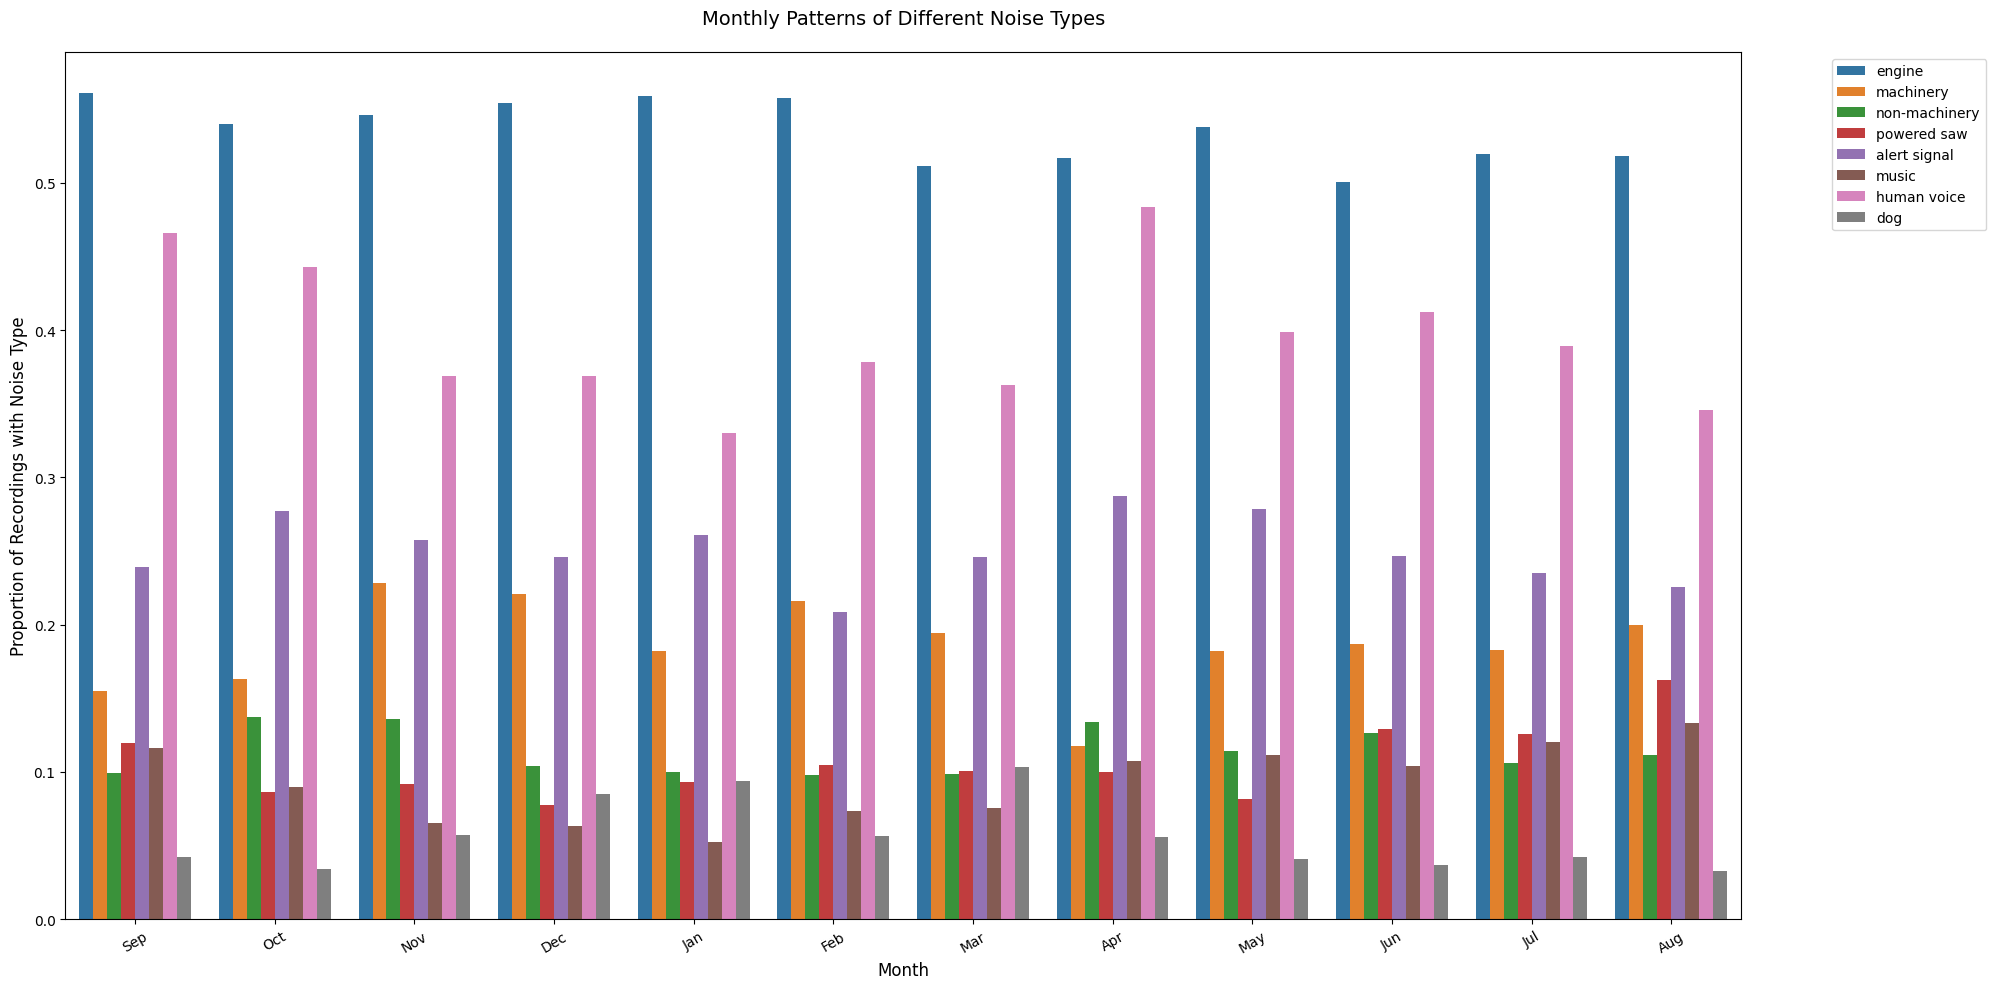

In [6]:
# Create monthly patterns
plt.figure(figsize=(20, 10))
noise_data['month'] = noise_data['date'].dt.month
monthly_means = noise_data.groupby('month')[presence_cols].mean().rename(columns=simplified_labels)
monthly_means = monthly_means.reindex([9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8])
month_map = {9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec',
            1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
            5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug'}
monthly_means.index = [month_map[x] for x in monthly_means.index]

# Using seaborn's barplot for monthly data as well
plot_data = monthly_means.reset_index().melt(id_vars='index')
sns.barplot(data=plot_data, x='index', y='value', hue='variable')
plt.title('Monthly Patterns of Different Noise Types', pad=20, size=14)
plt.xlabel('Month', size=12)
plt.ylabel('Proportion of Recordings with Noise Type', size=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(rotation=30)

# Save the figure to a file
plt.savefig("./Figures/monthly_patterns.png", dpi=300, bbox_inches='tight')

# Layout adjustments and show
plt.tight_layout()
plt.show()

Monthly noise pattern observations:
- Again, engine sounds are relatively constant throughout the year.
- There is a spike in human voice captures in April. Human voice recordings are also relatively high in September and October.
- Machinery recordings fluctuate in frequency throughout the year but are captured slightly less frequently in April.

### Noise summary statistics

In [7]:
# Summary statistics
print("\nOverall prevalence of each noise type:")
prevalence = noise_data[presence_cols].mean().sort_values(ascending=False)
print(prevalence)

print("\nNumber of annotations per recording:")
print(noise_data['annotation_count'].describe())


Overall prevalence of each noise type:
1_engine_presence                  0.538453
7_human-voice_presence             0.388978
5_alert-signal_presence            0.251237
2_machinery-impact_presence        0.188178
3_non-machinery-impact_presence    0.113107
4_powered-saw_presence             0.103431
6_music_presence                   0.087416
8_dog_presence                     0.060112
dtype: float64

Number of annotations per recording:
count    17983.000000
mean         3.230607
std          1.089700
min          3.000000
25%          3.000000
50%          3.000000
75%          3.000000
max         22.000000
Name: annotation_count, dtype: float64


### Calculate and analyze recordings per school

In [8]:
# Let's add a column academic_year to noise_data for easier analysis
# Create academic_year by checking if date is before or after September 1st
noise_data['academic_year'] = noise_data['date'].apply(
    lambda x: f"{x.year}-{x.year + 1}" if x.month >= 9 else f"{x.year - 1}-{x.year}"
)

In [9]:
# First, get our sensor-level recordings by year
sensor_recordings = noise_data.groupby(['sensor_id', 'academic_year']).size().reset_index(name='num_recordings')

# Get list of sensor columns from coverage_matrix 
sensor_cols = [col for col in coverage_matrix.columns if col.startswith('sensor_')]

# Initialize DataFrame to store school recordings
school_recordings = []

# For each school
for idx, row in coverage_matrix.iterrows():
    school_dbn = row['DBN']
    
    # Get the sensors that cover this school
    school_sensors = []
    for col in sensor_cols:
        if row[col] == 1:
            sensor_id = int(col.replace('sensor_', ''))
            school_sensors.append(sensor_id)
    
    # For each academic year, sum the recordings from all sensors covering this school
    for year in sensor_recordings['academic_year'].unique():
        year_recordings = sensor_recordings[
            (sensor_recordings['sensor_id'].isin(school_sensors)) & 
            (sensor_recordings['academic_year'] == year)
        ]['num_recordings'].sum()
        
        school_recordings.append({
            'DBN': school_dbn,
            'academic_year': year,
            'num_recordings': year_recordings
        })

# Convert to DataFrame
school_recordings_df = pd.DataFrame(school_recordings)

#### Boxplot for Distribution of Recordings per School by Academic Year

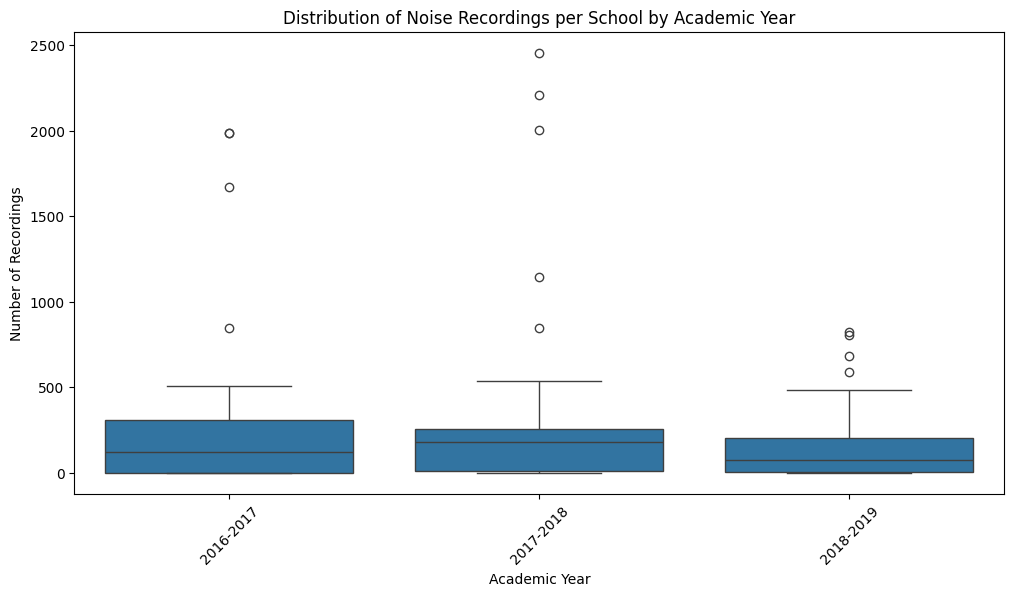


Summary statistics of recordings per school:
               count        mean         std  min    25%    50%    75%     max
academic_year                                                                 
2016-2017       54.0  253.203704  436.946626  0.0   0.00  122.5  304.5  1988.0
2017-2018       54.0  315.203704  524.847125  0.0  11.00  177.0  252.0  2457.0
2018-2019       54.0  167.277778  215.232425  0.0   4.25   75.5  204.0   822.0


In [10]:
# Create boxplot of recordings per school
plt.figure(figsize=(12, 6))
sns.boxplot(data=school_recordings_df, x='academic_year', y='num_recordings')
plt.title('Distribution of Noise Recordings per School by Academic Year')
plt.xlabel('Academic Year')
plt.ylabel('Number of Recordings')
plt.xticks(rotation=45)
plt.show()

# Print summary statistics
print("\nSummary statistics of recordings per school:")
print(school_recordings_df.groupby('academic_year')['num_recordings'].describe())

There's a fair amount of outlier schools with a high number of recordings. Let's identify these schools.

In [11]:
# Identify schools with notably high or low recording counts
for year in school_recordings_df['academic_year'].unique():
    year_data = school_recordings_df[school_recordings_df['academic_year'] == year]
    Q1 = year_data['num_recordings'].quantile(0.25)
    Q3 = year_data['num_recordings'].quantile(0.75)
    IQR = Q3 - Q1
    
    outliers = year_data[
        (year_data['num_recordings'] < (Q1 - 1.5 * IQR)) |
        (year_data['num_recordings'] > (Q3 + 1.5 * IQR))
    ]
    
    if len(outliers) > 0:
        print(f"\nOutlier schools in {year}:")
        print(f"Expected range: {Q1 - 1.5 * IQR:.0f} to {Q3 + 1.5 * IQR:.0f} recordings")
        print(outliers[['DBN', 'num_recordings']].sort_values('num_recordings'))


Outlier schools in 2016-2017:
Expected range: -457 to 761 recordings
      DBN  num_recordings
9  02M260             848
6  02M534            1668
3  02M041            1984
0  84M202            1988

Outlier schools in 2017-2018:
Expected range: -350 to 614 recordings
       DBN  num_recordings
64  02M442             847
10  02M260            1144
7   02M534            2006
4   02M041            2206
1   84M202            2457

Outlier schools in 2018-2019:
Expected range: -295 to 504 recordings
       DBN  num_recordings
11  02M260             589
5   02M041             679
8   02M534             807
2   84M202             822


#### Boxplot for Distribution of Recordings per School by Academic Year, Outliers Removed

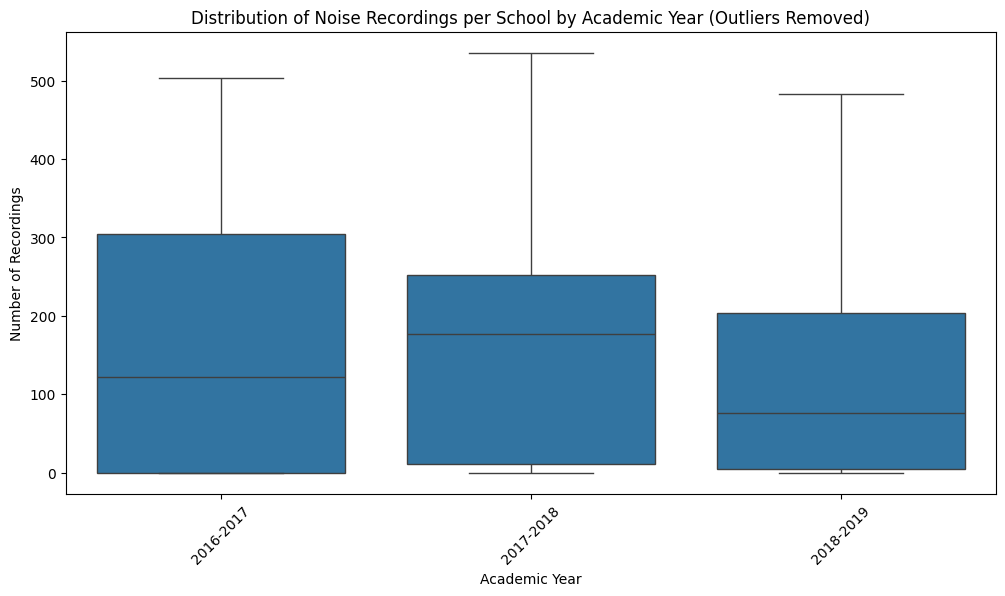

In [12]:
# Create boxplot of recordings per school
plt.figure(figsize=(12, 6))
sns.boxplot(data=school_recordings_df, x='academic_year', y='num_recordings', showfliers=False)
plt.title('Distribution of Noise Recordings per School by Academic Year (Outliers Removed)')
plt.xlabel('Academic Year')
plt.ylabel('Number of Recordings')
plt.xticks(rotation=45)
plt.show()

## Recording frequency patterns for each school
We will create a `for` loop that loops through every school in our `coverage_matrix` dataframe and creates a recording frequency matrix for it. This coverage matrix will give an overview of how frequently sensors took recordings for each school.

This frequency matrix will have school years 2016-17 through 2018-19 on the x-axis with each year delineated by a dashed red vertical line in the matrix itself.

Also, the time of day will be on the y-axis. Times are in 24-hour format with 0 at the bottom and 23 at the top.

In [13]:
# NOTE: Originally, this portion of the code looped through all schools in our coverage map and created one frequency
# matrix graph for each school.
# In an effort to keep the file size low enough to properly display on GitHub, I have trimmed the code to only display
# the first 4 schools.

# Get list of all schools
schools = coverage_matrix['DBN'].unique()

# Create a more detailed recording pattern dataframe for each school
school_patterns = []

# For each school, get recording patterns across time
for dbn in schools:
    # Get sensors that cover this school
    school_sensors = []
    for col in sensor_cols:
        if coverage_matrix.loc[coverage_matrix['DBN'] == dbn, col].iloc[0] == 1:
            sensor_id = int(col.replace('sensor_', ''))
            school_sensors.append(sensor_id)
    
    # Get all recordings from these sensors
    school_data = noise_data[noise_data['sensor_id'].isin(school_sensors)].copy()
    school_data['DBN'] = dbn
    school_patterns.append(school_data)

# Combine all school patterns
school_patterns_df = pd.concat(school_patterns)

In [14]:
# NOTE: Originally, this portion of the code looped through all schools in our coverage map and created one frequency
# matrix graph for each school.
# In an effort to keep the file size low enough to properly display on GitHub, I have trimmed the code to display only
# the first 4 schools.

# ///
# Original code:
# # Create subplots for each school
# # Let's do 4 schools per figure to keep it manageable
# schools_per_figure = 4
# num_figures = (len(schools) + schools_per_figure - 1) // schools_per_figure

# for fig_num in range(num_figures):
#     fig, axes = plt.subplots(schools_per_figure, 1, figsize=(15, 4*schools_per_figure))
#     if schools_per_figure == 1:
#         axes = [axes]
    
#     # Get the schools for this figure
#     figure_schools = schools[fig_num*schools_per_figure:(fig_num+1)*schools_per_figure]
    
#     for idx, school in enumerate(figure_schools):
#         school_data = school_patterns_df[school_patterns_df['DBN'] == school]
        
#         # Create scatter plot
#         axes[idx].scatter(school_data['date'], 
#                          school_data['hour'],
#                          alpha=0.5,
#                          s=20)
        
#         # Add school info to title
#         axes[idx].set_title(f'School {school} Recording Pattern')
#         axes[idx].set_ylabel('Hour of Day')
#         axes[idx].grid(True, alpha=0.3)
        
#         # Add academic year divisions
#         for year in range(2016, 2020):
#             axes[idx].axvline(pd.Timestamp(f"{year}-09-01"), 
#                             color='r', 
#                             linestyle='--', 
#                             alpha=0.3)
        
#         # Rotate x-axis labels
#         axes[idx].tick_params(axis='x', rotation=45)
    
#     # Hide empty subplots if any
#     for idx in range(len(figure_schools), schools_per_figure):
#         if idx < len(axes):
#             axes[idx].set_visible(False)
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print summary statistics for each school in this figure
#     for school in figure_schools:
#         school_data = school_patterns_df[school_patterns_df['DBN'] == school]
#         print(f"\nSchool {school} Summary:")
#         print(f"Total recordings: {len(school_data)}")
#         print("\nRecordings by academic year:")
#         print(school_data.groupby('academic_year').size())
#         print("\nRecordings by month (averaged across years):")
#         monthly_avg = school_data.groupby(school_data['date'].dt.month).size() / \
#                      school_data['date'].dt.year.nunique()
#         print(monthly_avg.round(2))

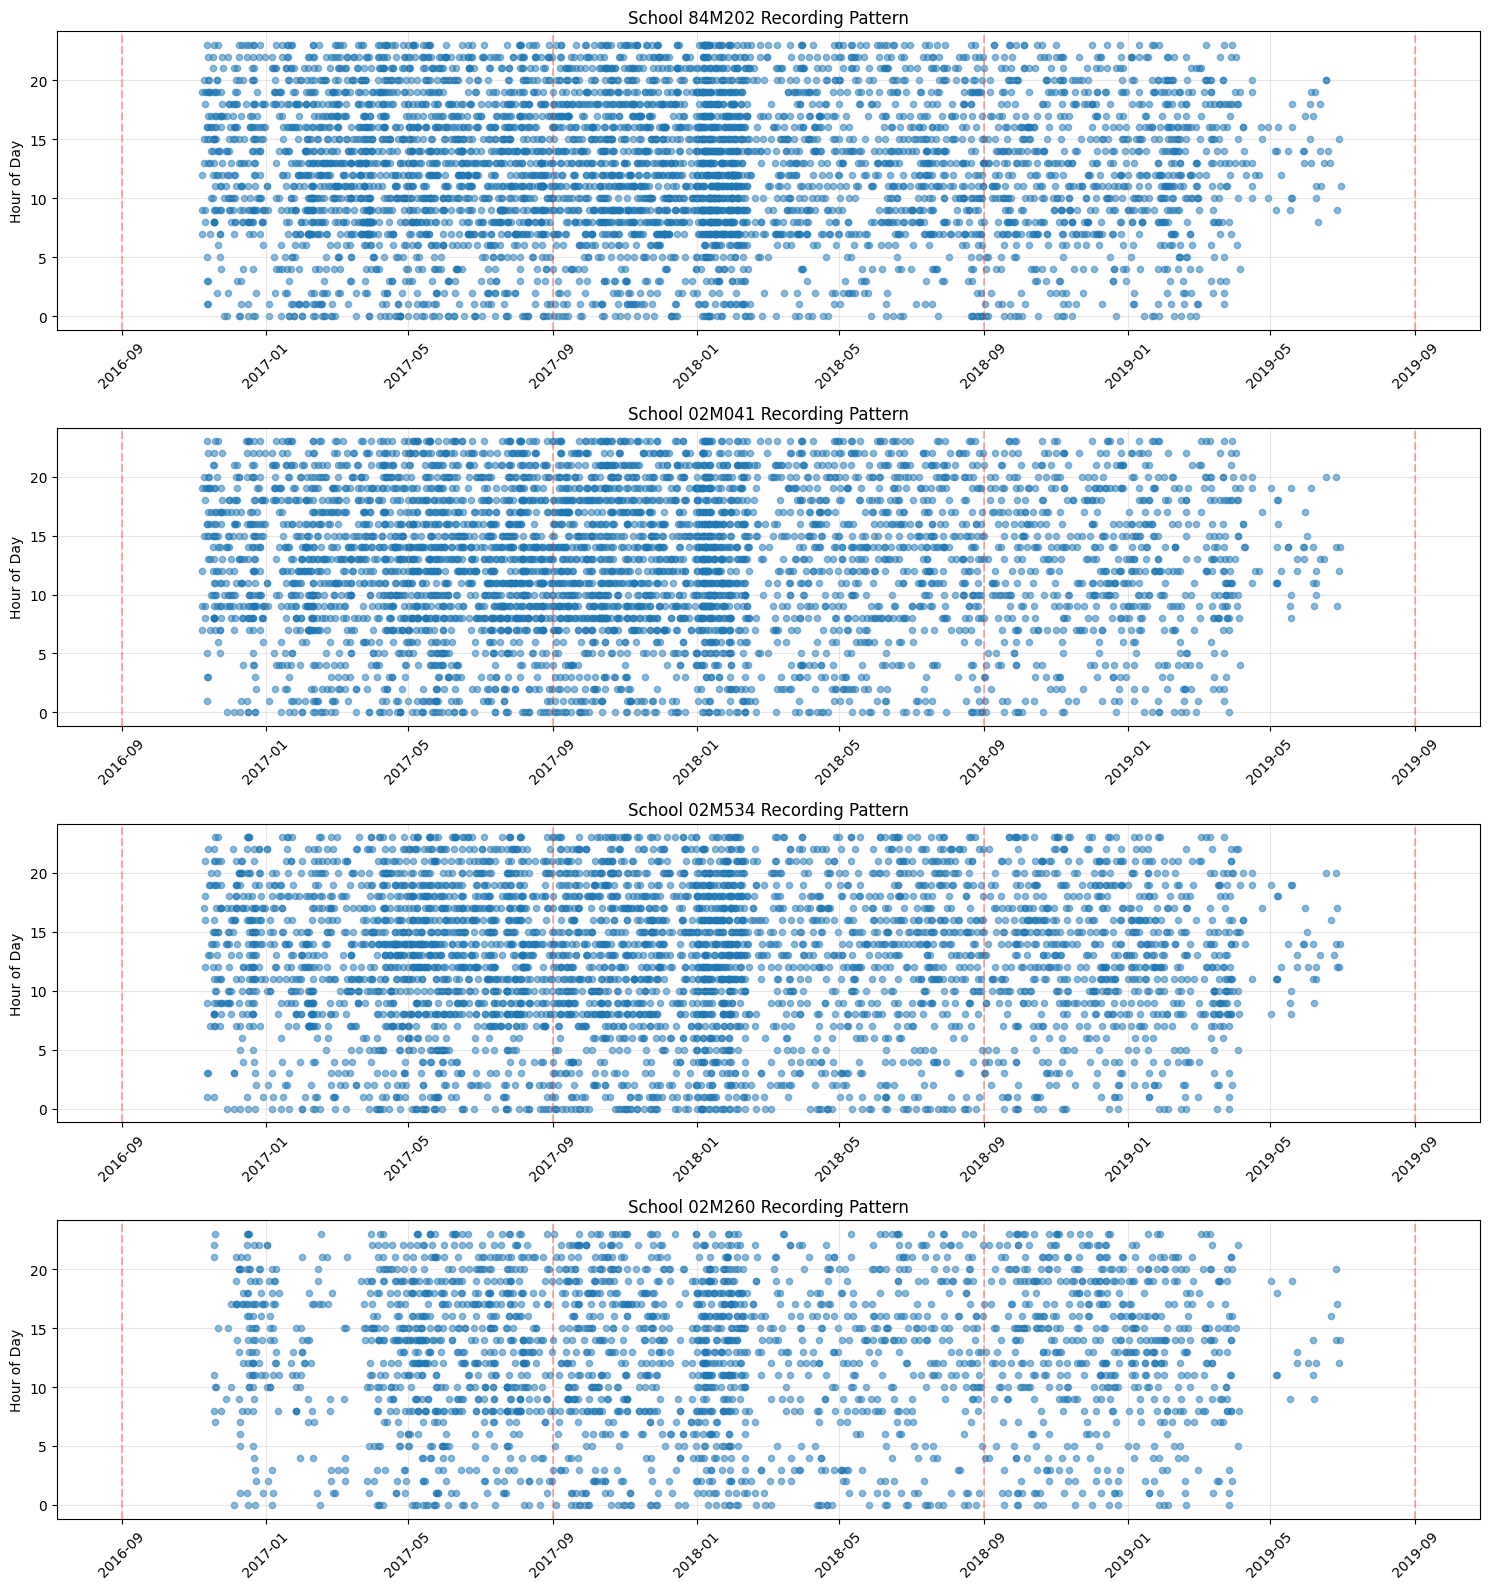


School 84M202 Summary:
Total recordings: 5267

Recordings by academic year:
academic_year
2016-2017    1988
2017-2018    2457
2018-2019     822
dtype: int64

Recordings by month (averaged across years):
date
1     199.75
2     136.25
3     120.75
4      87.00
5      93.00
6      87.25
7      89.50
8      93.00
9      81.75
10     91.25
11    118.75
12    118.50
dtype: float64

School 02M041 Summary:
Total recordings: 4869

Recordings by academic year:
academic_year
2016-2017    1984
2017-2018    2206
2018-2019     679
dtype: int64

Recordings by month (averaged across years):
date
1     163.00
2      96.25
3      92.50
4      89.75
5     110.50
6      81.75
7      94.75
8      95.50
9      90.00
10     90.25
11    101.50
12    111.50
dtype: float64

School 02M534 Summary:
Total recordings: 4481

Recordings by academic year:
academic_year
2016-2017    1668
2017-2018    2006
2018-2019     807
dtype: int64

Recordings by month (averaged across years):
date
1     158.00
2      88.00
3    

In [15]:
# ///
# Modified code:

# Select first 4 schools for plotting
schools_to_plot = schools[:4]

# Create subplot for just these 4 schools
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

# Plot only these 4 schools
for idx, school in enumerate(schools_to_plot):
    school_data = school_patterns_df[school_patterns_df['DBN'] == school]
    
    # Create scatter plot
    axes[idx].scatter(school_data['date'], 
                     school_data['hour'],
                     alpha=0.5,
                     s=20)
    
    # Add school info to title
    axes[idx].set_title(f'School {school} Recording Pattern')
    axes[idx].set_ylabel('Hour of Day')
    axes[idx].grid(True, alpha=0.3)
    
    # Add academic year divisions
    for year in range(2016, 2020):
        axes[idx].axvline(pd.Timestamp(f"{year}-09-01"), 
                        color='r', 
                        linestyle='--', 
                        alpha=0.3)
    
    # Rotate x-axis labels
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics for just these 4 schools
for school in schools_to_plot:
    school_data = school_patterns_df[school_patterns_df['DBN'] == school]
    print(f"\nSchool {school} Summary:")
    print(f"Total recordings: {len(school_data)}")
    print("\nRecordings by academic year:")
    print(school_data.groupby('academic_year').size())
    print("\nRecordings by month (averaged across years):")
    monthly_avg = school_data.groupby(school_data['date'].dt.month).size() / \
                 school_data['date'].dt.year.nunique()
    print(monthly_avg.round(2))

### Removing schools with few recordings

Notably, there are a few schools in our coverage are that have very few recordings. Let's remove schools with fewer than 15 recordings from our analysis.

In [16]:
# Copy school_recordings_df
school_recordings_df_copy = school_recordings_df.copy()

# Filter based on threshold
threshold = 15
school_recordings_df = school_recordings_df[school_recordings_df['num_recordings'] >= threshold]

In [17]:
# Get DBNs from filtered school_recordings_df
filtered_schools = school_recordings_df['DBN']

In [18]:
combined_summary_df

,DBN,school_name,enrollment,ell_pct,disability_pct,self_contained_pct,asian_pct,black_pct,hispanic_pct,white_pct,student_attendance_rate,chronic_absence_pct,teacher_attendance_rate,academic_year,coverage,grade_level
0,01M015,P.S. 015 Roberto Clemente,161,0.075,0.304,0.031,0.068,0.298,0.584,0.025,0.938,0.215,0.982,2016-2017,False,lg
1,01M019,P.S. 019 Asher Levy,247,0.036,0.340,0.117,0.077,0.202,0.664,0.053,0.910,0.324,0.972,2016-2017,False,lg
2,01M020,P.S. 020 Anna Silver,499,0.186,0.224,0.072,0.329,0.098,0.491,0.042,0.929,0.256,0.962,2016-2017,False,lg
3,01M034,P.S. 034 Franklin D. Roosevelt,337,0.080,0.380,0.021,0.053,0.297,0.614,0.030,0.912,0.305,0.972,2016-2017,False,lg
4,01M064,P.S. 064 Robert Simon,226,0.044,0.354,0.009,0.058,0.190,0.673,0.071,0.913,0.346,0.969,2016-2017,False,lg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5299,24Q550,High School for Arts and Business,812,0.095,0.158,0.001,0.085,0.079,0.765,0.054,0.912,0.249,0.965,2018-2019,True,hs
5300,28Q220,P.S. 220 Edward Mandel,670,0.224,0.113,0.016,0.330,0.076,0.200,0.357,0.944,0.162,0.955,2018-2019,True,lg
5301,84M174,Success Academy Union Square (Manhattan 1),619,0.031,0.195,0.039,0.186,0.221,0.258,0.283,NaN,NaN,NaN,2018-2019,True,lg
5302,84M202,Great Oaks Charter School,215,0.042,0.302,0.028,0.084,0.256,0.619,0.028,NaN,NaN,NaN,2018-2019,True,lg


In [19]:
# Copy coverage_matrix
coverage_matrix_copy = coverage_matrix

In [20]:
# Filter coverage_matrix based on filtered_schools
coverage_matrix = coverage_matrix[coverage_matrix['DBN'].isin(filtered_schools)]

In [21]:
# Also filter school_patterns_df
# But first make a copy
school_patterns_df_copy = school_patterns_df.copy()

school_patterns_df = school_patterns_df[school_patterns_df['DBN'].isin(filtered_schools)]

#### Update coverage in other dataframes

In [22]:
# Let's update our coverage values in our other dataframes, since our coverage has changed.
coverage_change_dfs = [combined_summary_df, combined_lg_achievement_df, combined_hs_achievement_df, 
                       elem_middle_schools, high_schools]

# Loop through list of dataframes to update
for df in coverage_change_dfs:
    df['coverage'] = df['DBN'].isin(filtered_schools)

---

## Trends in school demographic & achievement data <a name="demographic-data"></a>

### Demographic data

In [23]:
# Filter for covered schools
coverage_combined_summary_df = combined_summary_df[combined_summary_df['coverage']==True]

# Use a single indexing operation with combined conditions
covered_sum_16_17 = coverage_combined_summary_df[coverage_combined_summary_df['academic_year']=='2016-2017']
covered_sum_17_18 = coverage_combined_summary_df[coverage_combined_summary_df['academic_year']=='2017-2018']
covered_sum_18_19 = coverage_combined_summary_df[coverage_combined_summary_df['academic_year']=='2018-2019']

# Filter for non-covered schools
non_coverage_combined_summary_df = combined_summary_df[combined_summary_df['coverage']==False]

# Non-coverage area summaries, separated by academic year
non_covered_sum_16_17 = non_coverage_combined_summary_df[non_coverage_combined_summary_df['academic_year']=='2016-2017']
non_covered_sum_17_18 = non_coverage_combined_summary_df[non_coverage_combined_summary_df['academic_year']=='2017-2018']
non_covered_sum_18_19 = non_coverage_combined_summary_df[non_coverage_combined_summary_df['academic_year']=='2018-2019']

In [24]:
demographic_features = ['enrollment', 'ell_pct', 'disability_pct', 'self_contained_pct',
                        'asian_pct', 'black_pct', 'hispanic_pct', 'white_pct',
                        'student_attendance_rate', 'chronic_absence_pct',
                        'teacher_attendance_rate']

### Demographic summaries by academic year: Coverage vs. non-coverage schools <a name="demographic-summaries"></a>

#### Trends in demographics over time

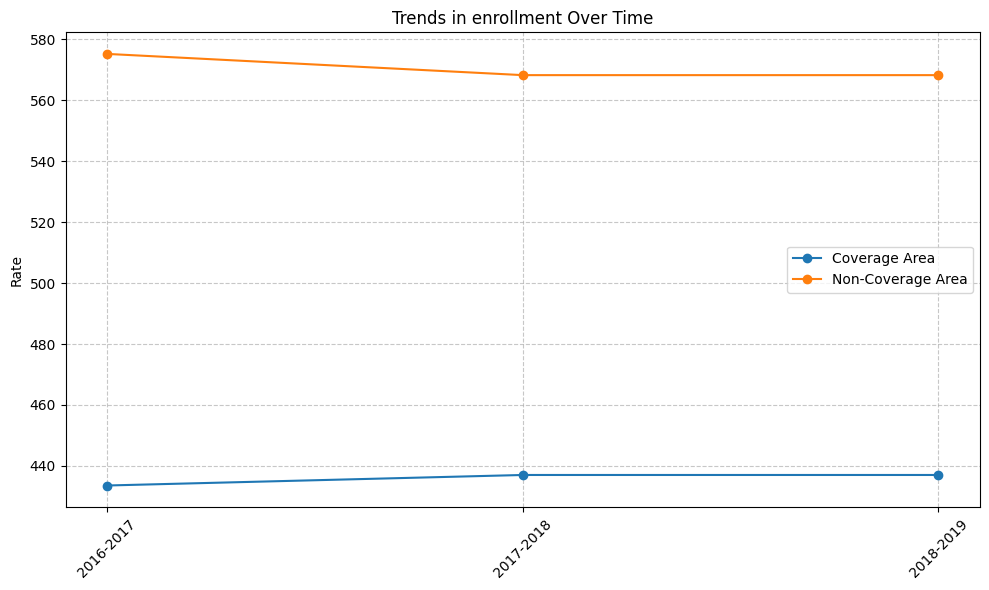


Changes in enrollment:

Coverage Area:
2016-2017: 433.568
2018-2019: 437.023
Change: 3.455

Non-Coverage Area:
2016-2017: 575.232
2018-2019: 568.266
Change: -6.966



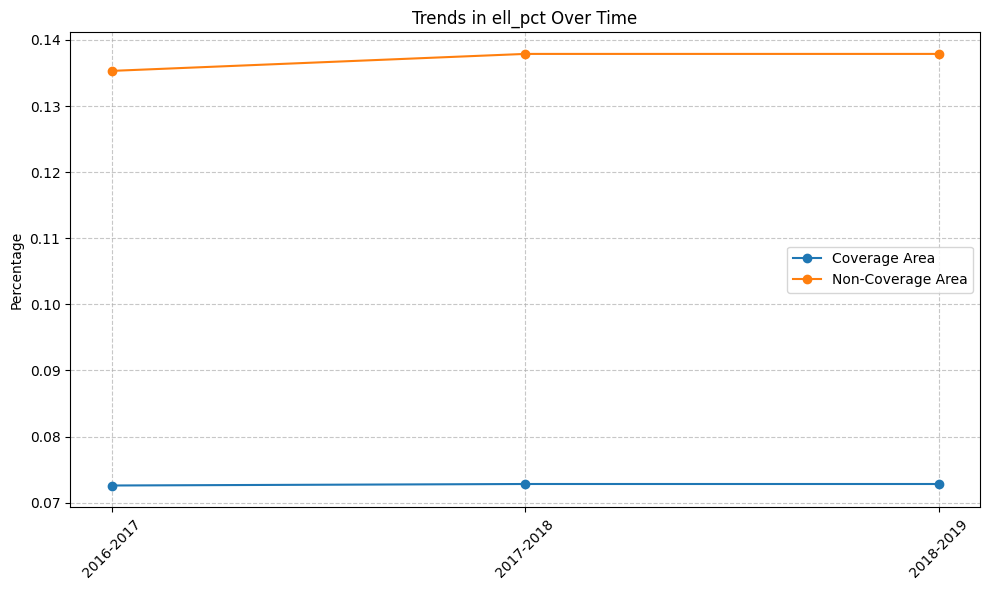


Changes in ell_pct:

Coverage Area:
2016-2017: 0.073
2018-2019: 0.073
Change: 0.000

Non-Coverage Area:
2016-2017: 0.135
2018-2019: 0.138
Change: 0.003



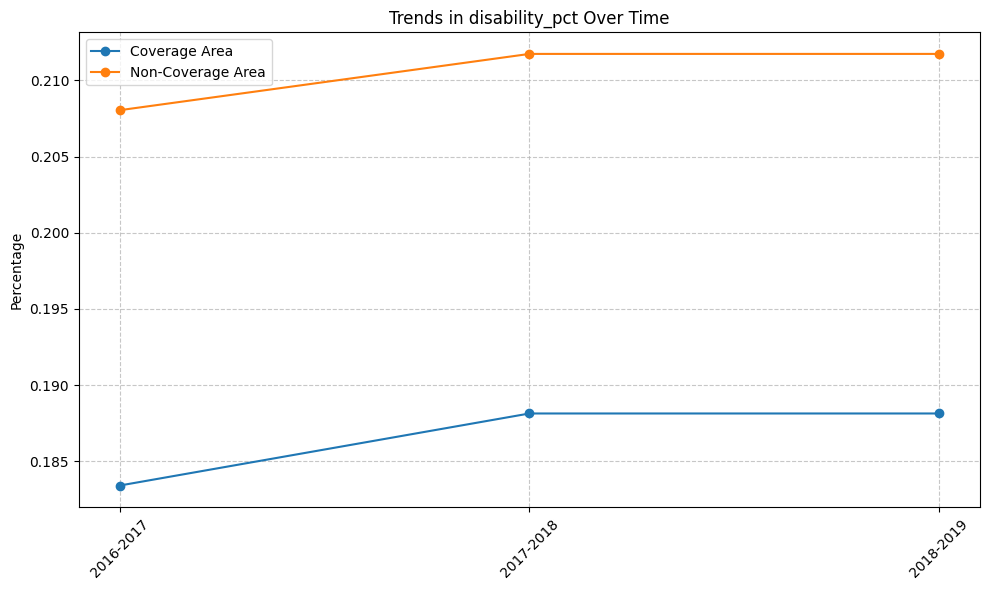


Changes in disability_pct:

Coverage Area:
2016-2017: 0.183
2018-2019: 0.188
Change: 0.005

Non-Coverage Area:
2016-2017: 0.208
2018-2019: 0.212
Change: 0.004



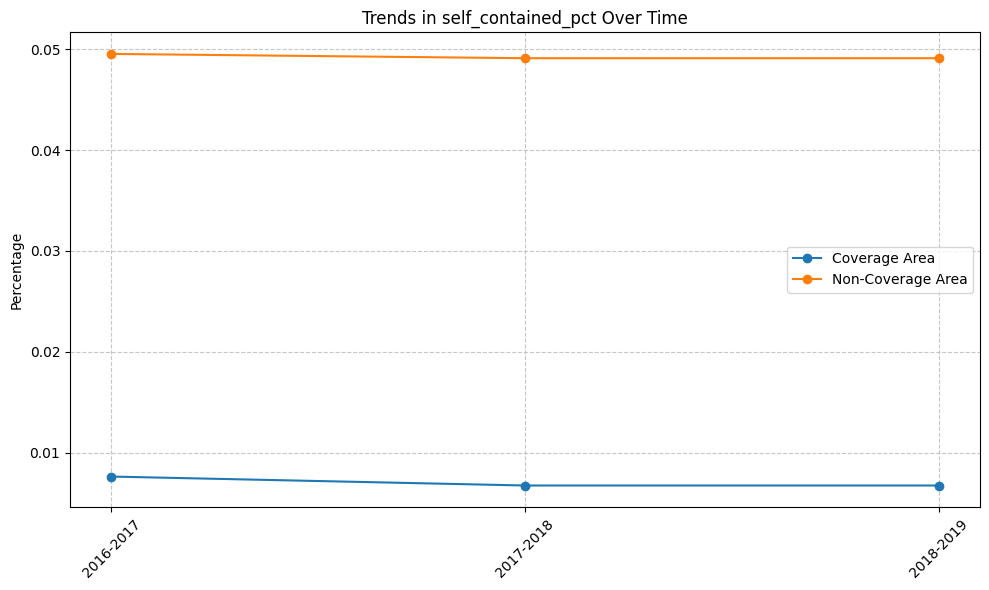


Changes in self_contained_pct:

Coverage Area:
2016-2017: 0.008
2018-2019: 0.007
Change: -0.001

Non-Coverage Area:
2016-2017: 0.050
2018-2019: 0.049
Change: -0.000



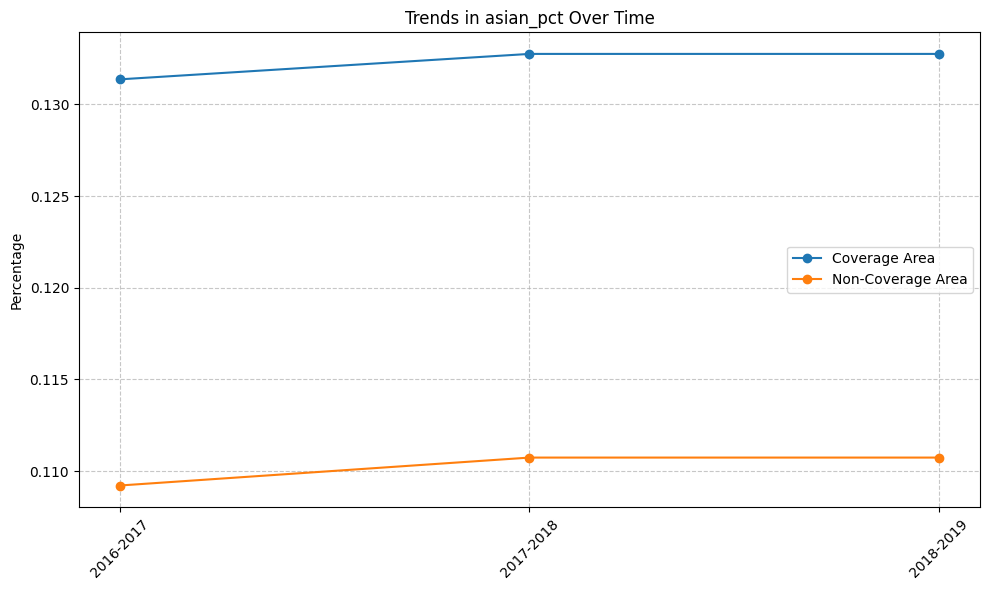


Changes in asian_pct:

Coverage Area:
2016-2017: 0.131
2018-2019: 0.133
Change: 0.001

Non-Coverage Area:
2016-2017: 0.109
2018-2019: 0.111
Change: 0.002



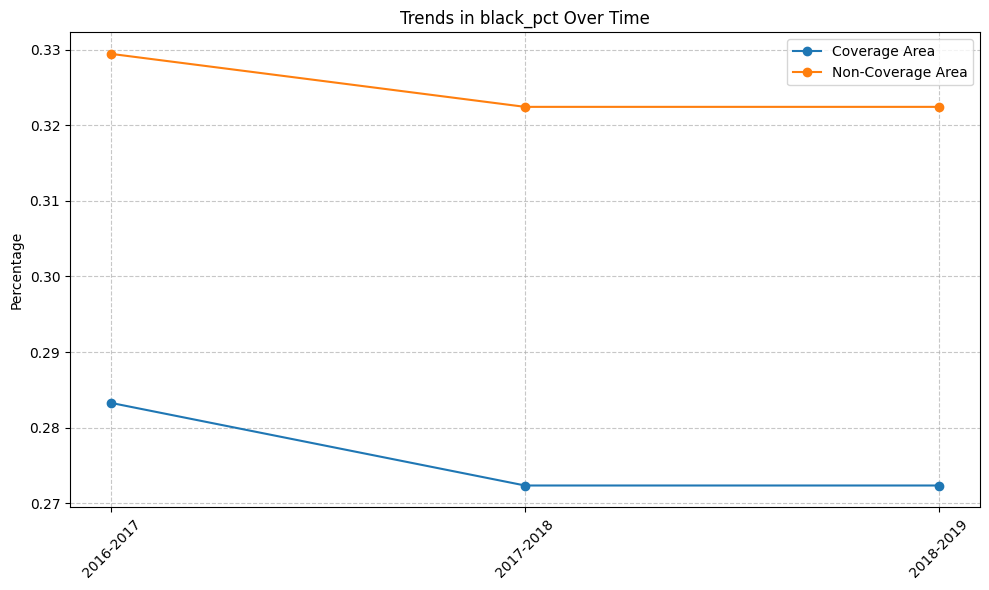


Changes in black_pct:

Coverage Area:
2016-2017: 0.283
2018-2019: 0.272
Change: -0.011

Non-Coverage Area:
2016-2017: 0.329
2018-2019: 0.322
Change: -0.007



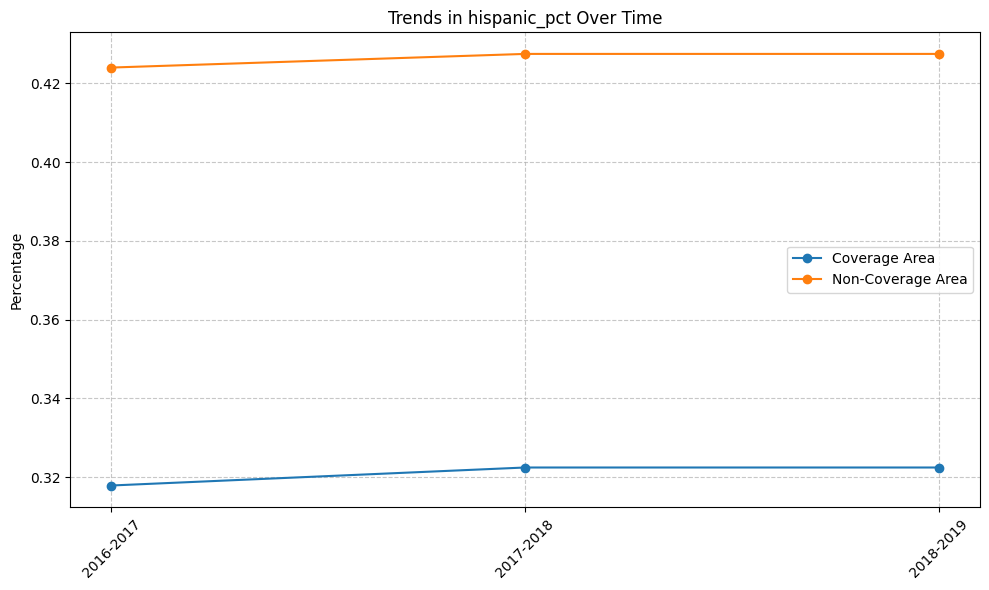


Changes in hispanic_pct:

Coverage Area:
2016-2017: 0.318
2018-2019: 0.322
Change: 0.005

Non-Coverage Area:
2016-2017: 0.424
2018-2019: 0.427
Change: 0.003



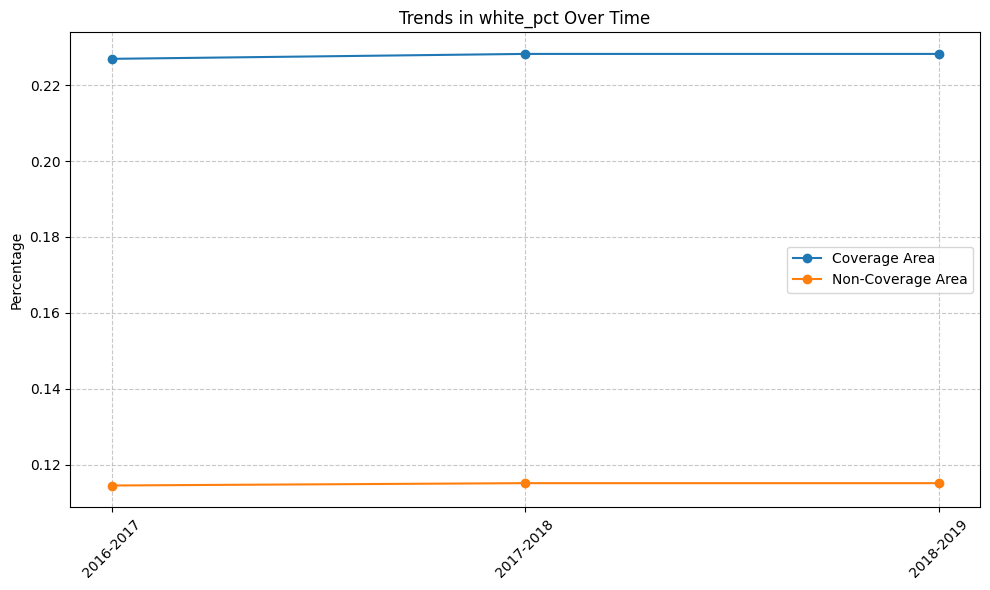


Changes in white_pct:

Coverage Area:
2016-2017: 0.227
2018-2019: 0.228
Change: 0.001

Non-Coverage Area:
2016-2017: 0.115
2018-2019: 0.115
Change: 0.001



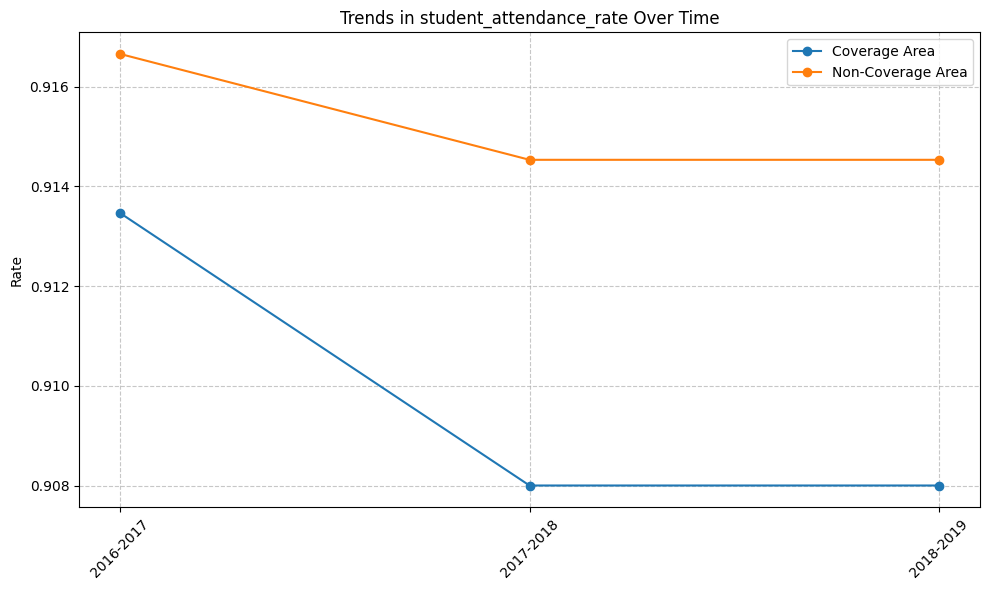


Changes in student_attendance_rate:

Coverage Area:
2016-2017: 0.913
2018-2019: 0.908
Change: -0.005

Non-Coverage Area:
2016-2017: 0.917
2018-2019: 0.915
Change: -0.002



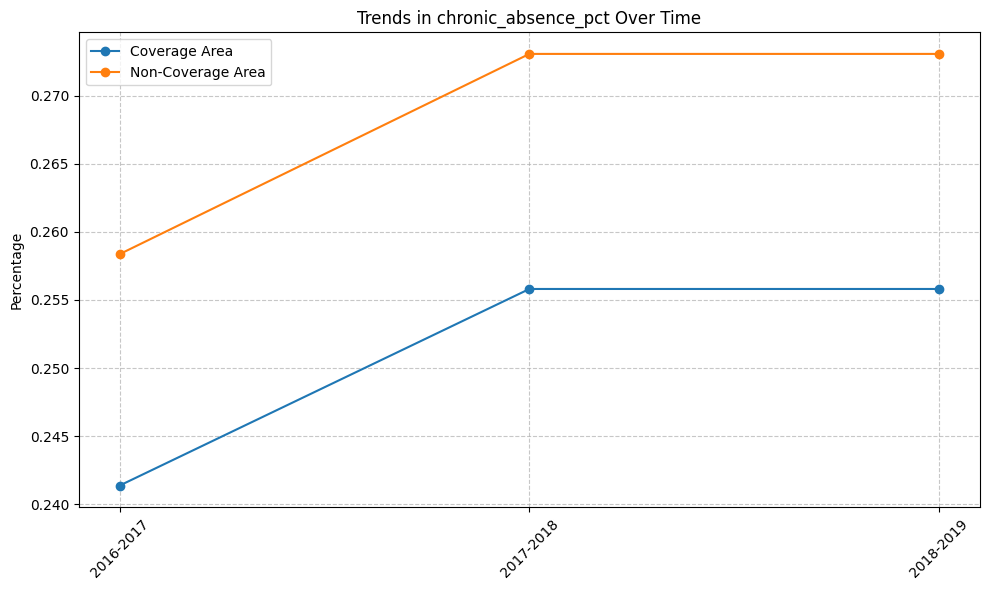


Changes in chronic_absence_pct:

Coverage Area:
2016-2017: 0.241
2018-2019: 0.256
Change: 0.014

Non-Coverage Area:
2016-2017: 0.258
2018-2019: 0.273
Change: 0.015



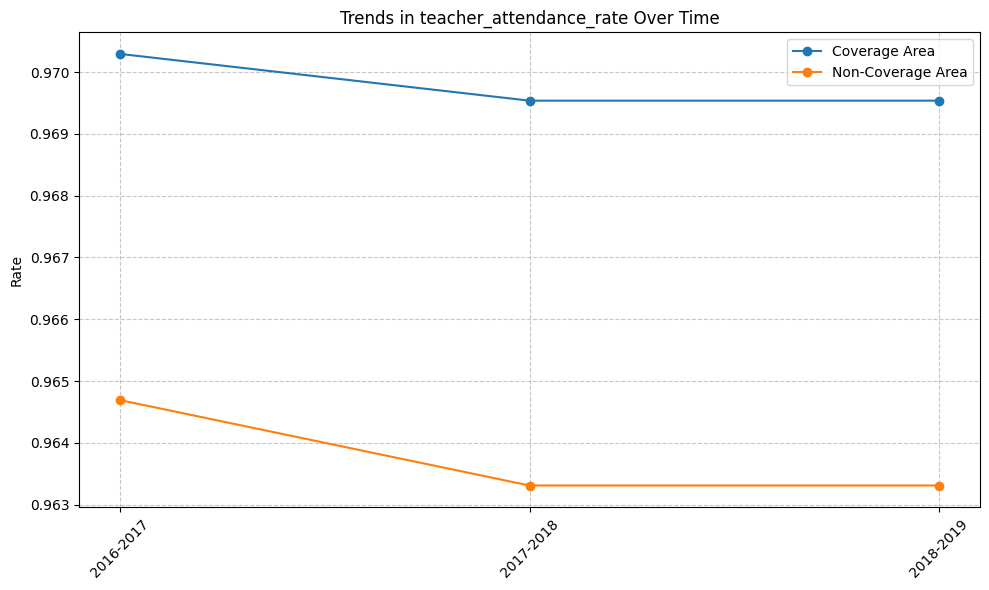


Changes in teacher_attendance_rate:

Coverage Area:
2016-2017: 0.970
2018-2019: 0.970
Change: -0.001

Non-Coverage Area:
2016-2017: 0.965
2018-2019: 0.963
Change: -0.001



In [25]:
# Calculate means for each year and area
coverage_sum_means = {
    '2016-2017': covered_sum_16_17[demographic_features].mean(),
    '2017-2018': covered_sum_17_18[demographic_features].mean(),
    '2018-2019': covered_sum_18_19[demographic_features].mean()
}

non_coverage_sum_means = {
    '2016-2017': non_covered_sum_16_17[demographic_features].mean(),
    '2017-2018': non_covered_sum_17_18[demographic_features].mean(),
    '2018-2019': non_covered_sum_18_19[demographic_features].mean()
}

# Create DataFrames for easier plotting
coverage_sum_trends = pd.DataFrame(coverage_sum_means)
non_coverage_sum_trends = pd.DataFrame(non_coverage_sum_means)

# Plot trends for each demographic feature
for feature in demographic_features:
    plt.figure(figsize=(10, 6))
    
    # Plot both coverage and non-coverage trends
    plt.plot(coverage_sum_trends.columns, coverage_sum_trends.loc[feature], 
             marker='o', label='Coverage Area')
    plt.plot(non_coverage_sum_trends.columns, non_coverage_sum_trends.loc[feature], 
             marker='o', label='Non-Coverage Area')
    
    plt.title(f'Trends in {feature} Over Time')
    plt.ylabel('Percentage' if 'pct' in feature else 'Rate')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Print numeric changes
    print(f"\nChanges in {feature}:")
    print("\nCoverage Area:")
    print(f"2016-2017: {coverage_sum_trends.loc[feature, '2016-2017']:.3f}")
    print(f"2018-2019: {coverage_sum_trends.loc[feature, '2018-2019']:.3f}")
    print(f"Change: {coverage_sum_trends.loc[feature, '2018-2019'] - coverage_sum_trends.loc[feature, '2016-2017']:.3f}")
    
    print("\nNon-Coverage Area:")
    print(f"2016-2017: {non_coverage_sum_trends.loc[feature, '2016-2017']:.3f}")
    print(f"2018-2019: {non_coverage_sum_trends.loc[feature, '2018-2019']:.3f}")
    print(f"Change: {non_coverage_sum_trends.loc[feature, '2018-2019'] - non_coverage_sum_trends.loc[feature, '2016-2017']:.3f}")
    
    print("\n" + "="*50)

**Summary of school demographic trends:**<br>
While a gap exists between coverage and non-coverage schools, schools in both coverage and non-coverage areas seem to follow identical patterns.

### Lower grades achievement data by academic year: Coverage vs. non-coverage schools <a name="lg-achievement"></a>

In [26]:
# Filter for covered schools
coverage_lg_achievement_df = combined_lg_achievement_df[combined_lg_achievement_df['coverage']==True]

# Coverage area summaries, separated by academic year
covered_lg_ach_16_17 = coverage_lg_achievement_df[coverage_lg_achievement_df['academic_year']=='2016-2017']
covered_lg_ach_17_18 = coverage_lg_achievement_df[coverage_lg_achievement_df['academic_year']=='2017-2018']
covered_lg_ach_18_19 = coverage_lg_achievement_df[coverage_lg_achievement_df['academic_year']=='2018-2019']

# Filter for non-covered schools
non_coverage_lg_achievement_df = combined_lg_achievement_df[combined_lg_achievement_df['coverage']==False]

# Non-coverage area summaries, separated by academic year
non_covered_lg_ach_16_17 = non_coverage_lg_achievement_df[non_coverage_lg_achievement_df['academic_year']=='2016-2017']
non_covered_lg_ach_17_18 = non_coverage_lg_achievement_df[non_coverage_lg_achievement_df['academic_year']=='2017-2018']
non_covered_lg_ach_18_19 = non_coverage_lg_achievement_df[non_coverage_lg_achievement_df['academic_year']=='2018-2019']

In [27]:
lg_ach_features = ['achievement_score', 'ela_proficient_pct', 'ela_avg_proficiency', 'ela_lowest_third_proficiency', 
                   'math_proficient_pct', 'math_avg_proficiency', 'math_lowest_third_proficiency', 
                   'attendance_90_plus_pct']

#### Trends in lower-grade achievement data over time

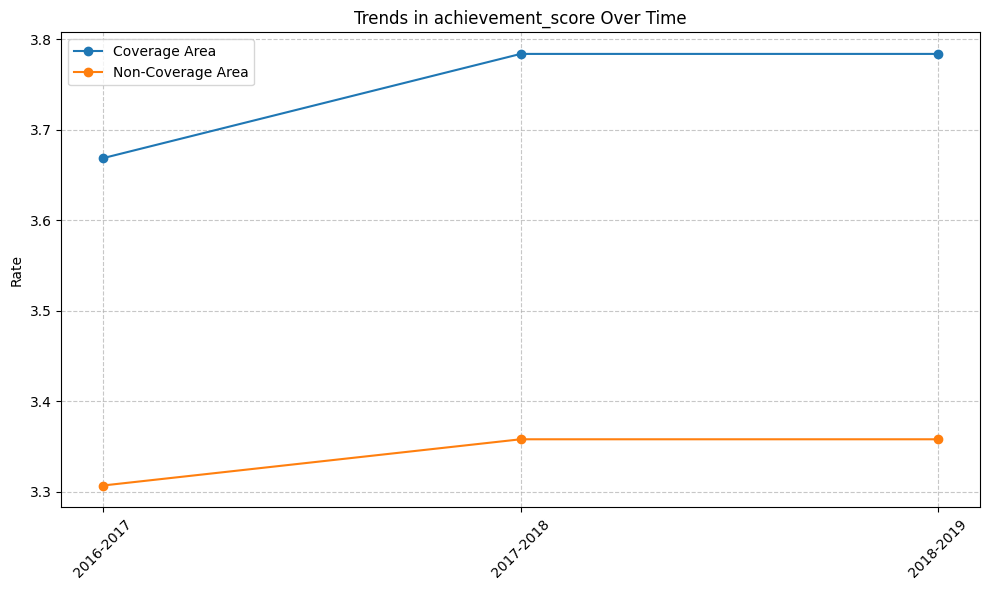


Changes in achievement_score:

Coverage Area:
2016-2017: 3.669
2018-2019: 3.784
Change: 0.115

Non-Coverage Area:
2016-2017: 3.307
2018-2019: 3.358
Change: 0.051



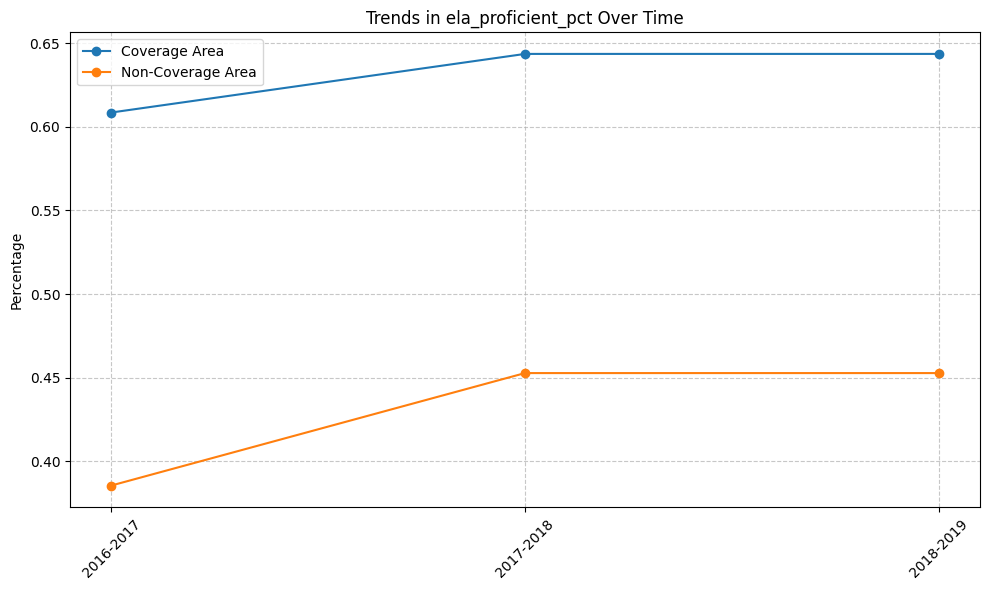


Changes in ela_proficient_pct:

Coverage Area:
2016-2017: 0.609
2018-2019: 0.644
Change: 0.035

Non-Coverage Area:
2016-2017: 0.386
2018-2019: 0.453
Change: 0.067



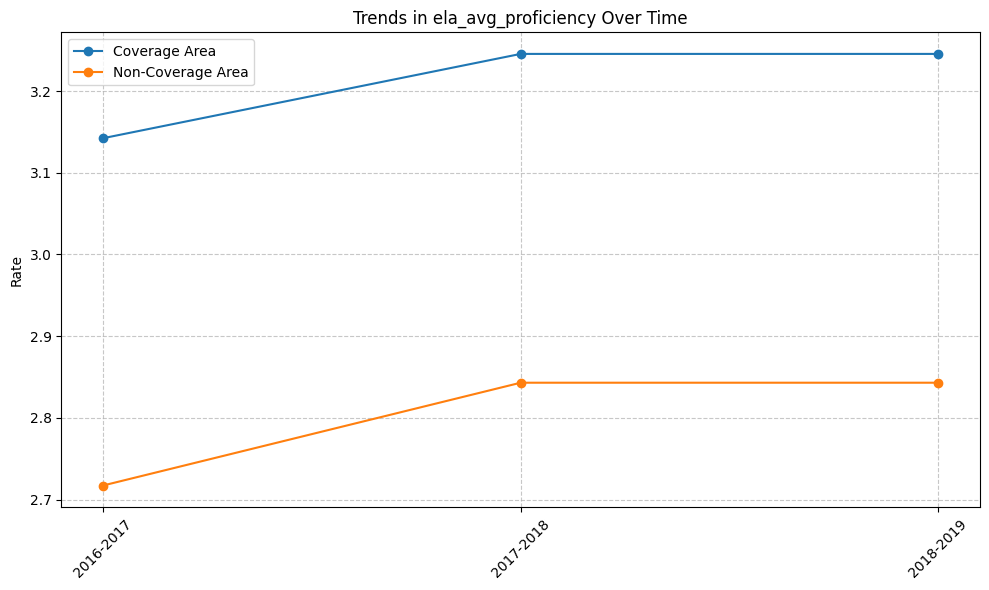


Changes in ela_avg_proficiency:

Coverage Area:
2016-2017: 3.142
2018-2019: 3.246
Change: 0.103

Non-Coverage Area:
2016-2017: 2.717
2018-2019: 2.843
Change: 0.126



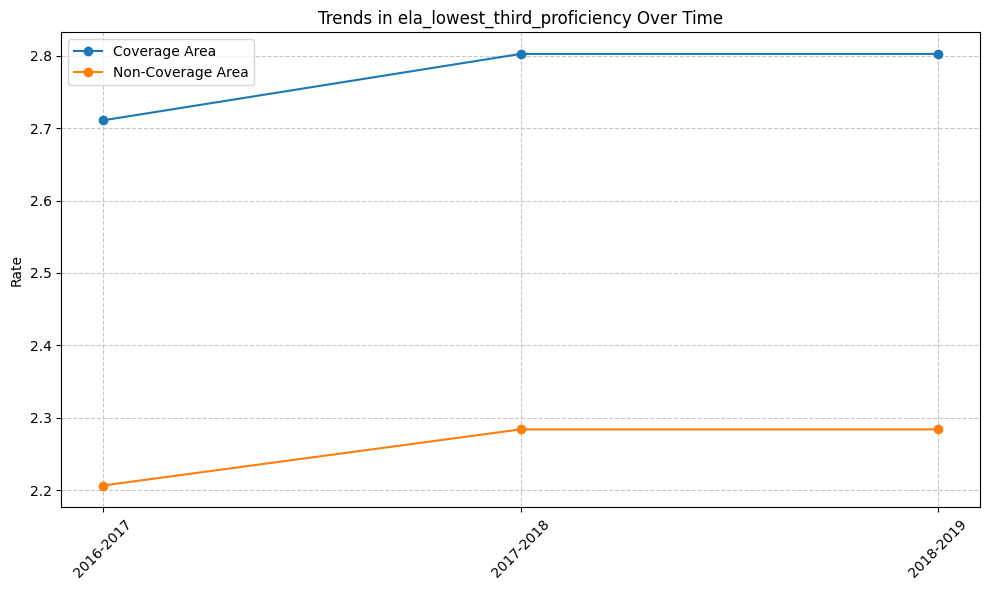


Changes in ela_lowest_third_proficiency:

Coverage Area:
2016-2017: 2.711
2018-2019: 2.802
Change: 0.092

Non-Coverage Area:
2016-2017: 2.207
2018-2019: 2.284
Change: 0.077



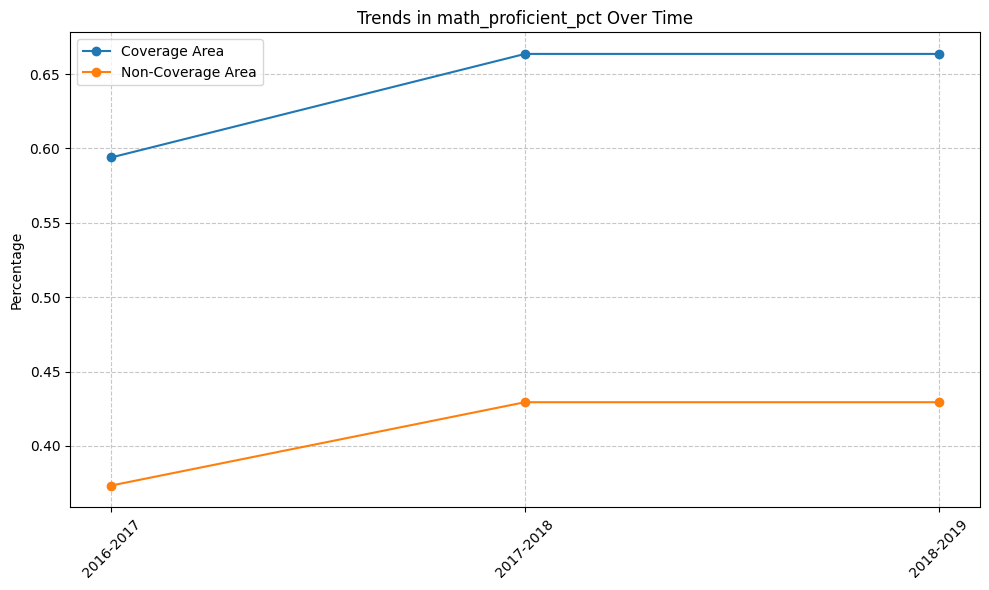


Changes in math_proficient_pct:

Coverage Area:
2016-2017: 0.594
2018-2019: 0.664
Change: 0.070

Non-Coverage Area:
2016-2017: 0.373
2018-2019: 0.429
Change: 0.056



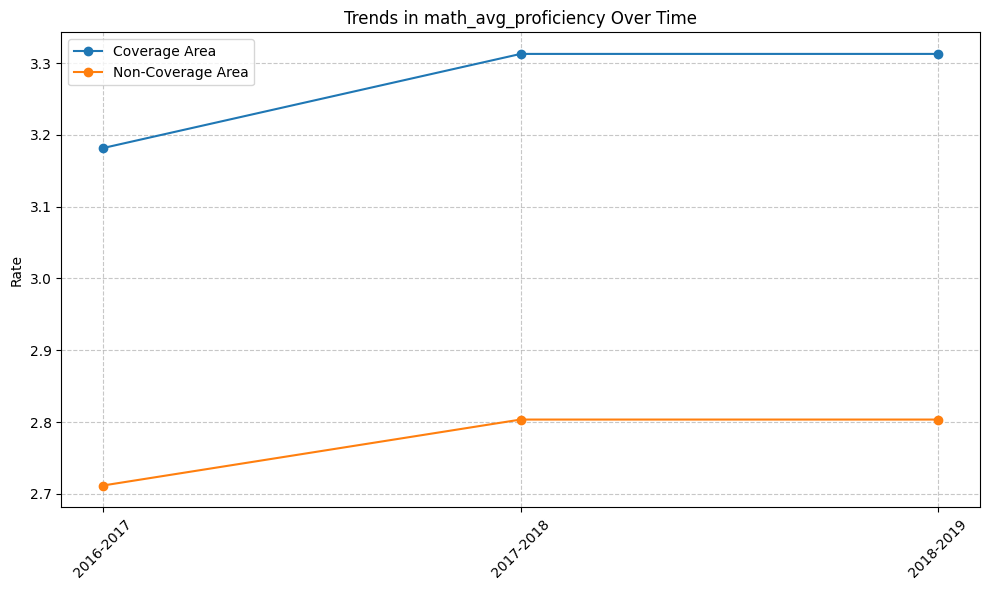


Changes in math_avg_proficiency:

Coverage Area:
2016-2017: 3.182
2018-2019: 3.313
Change: 0.131

Non-Coverage Area:
2016-2017: 2.712
2018-2019: 2.803
Change: 0.092



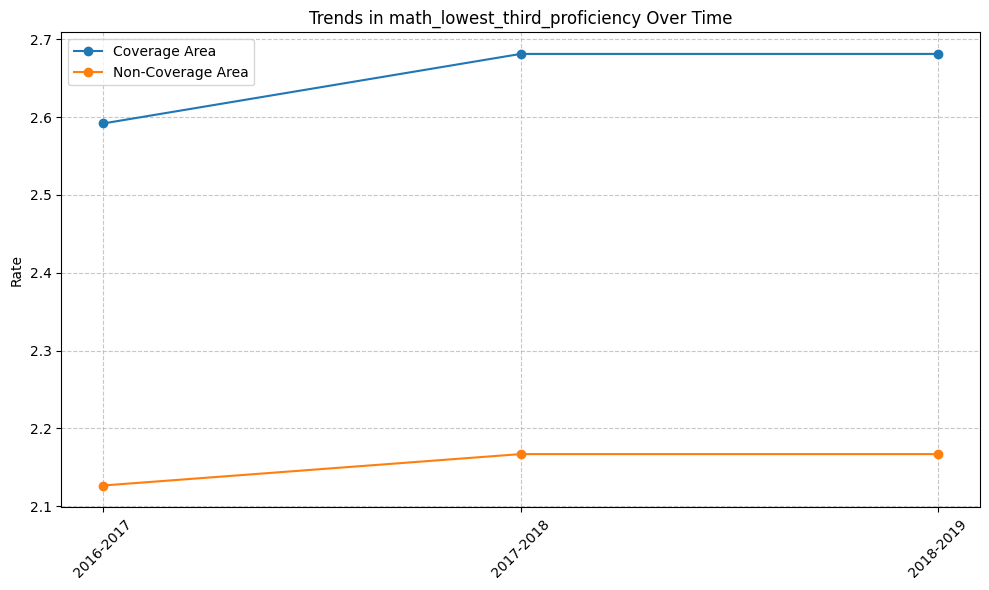


Changes in math_lowest_third_proficiency:

Coverage Area:
2016-2017: 2.592
2018-2019: 2.681
Change: 0.089

Non-Coverage Area:
2016-2017: 2.127
2018-2019: 2.167
Change: 0.040



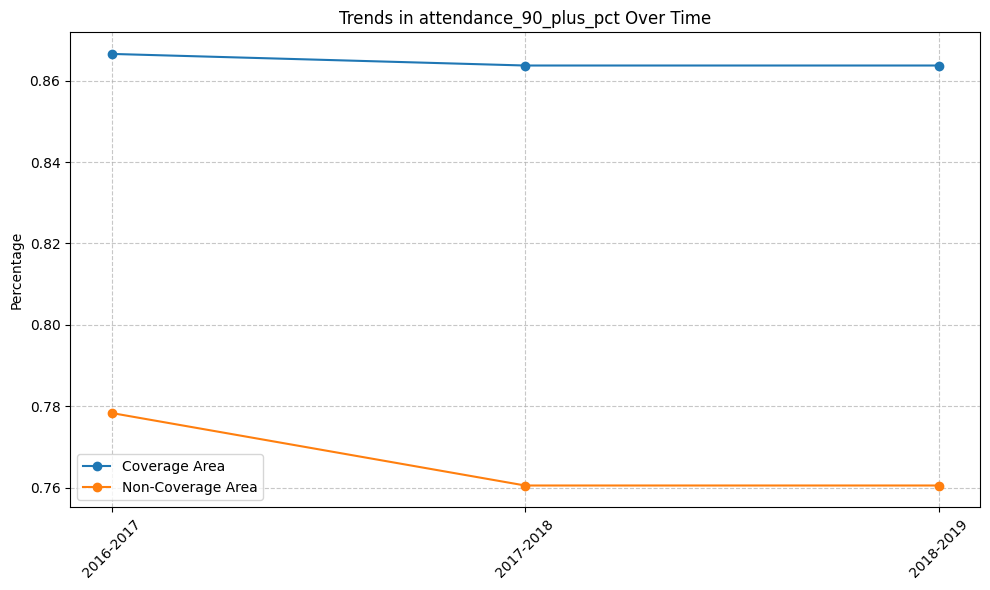


Changes in attendance_90_plus_pct:

Coverage Area:
2016-2017: 0.867
2018-2019: 0.864
Change: -0.003

Non-Coverage Area:
2016-2017: 0.778
2018-2019: 0.761
Change: -0.018



In [28]:
# Calculate means for each year and area
coverage_lg_ach_means = {
    '2016-2017': covered_lg_ach_16_17[lg_ach_features].mean(),
    '2017-2018': covered_lg_ach_17_18[lg_ach_features].mean(),
    '2018-2019': covered_lg_ach_18_19[lg_ach_features].mean()
}

non_coverage_lg_ach_means = {
    '2016-2017': non_covered_lg_ach_16_17[lg_ach_features].mean(),
    '2017-2018': non_covered_lg_ach_17_18[lg_ach_features].mean(),
    '2018-2019': non_covered_lg_ach_18_19[lg_ach_features].mean()
}

# Create DataFrames for easier plotting
coverage_lg_ach_trends = pd.DataFrame(coverage_lg_ach_means)
non_coverage_lg_ach_trends = pd.DataFrame(non_coverage_lg_ach_means)

# Plot trends for each demographic feature
for feature in lg_ach_features:
    plt.figure(figsize=(10, 6))
    
    # Plot both coverage and non-coverage trends
    plt.plot(coverage_lg_ach_trends.columns, coverage_lg_ach_trends.loc[feature], 
             marker='o', label='Coverage Area')
    plt.plot(non_coverage_lg_ach_trends.columns, non_coverage_lg_ach_trends.loc[feature], 
             marker='o', label='Non-Coverage Area')
    
    plt.title(f'Trends in {feature} Over Time')
    plt.ylabel('Percentage' if 'pct' in feature else 'Rate')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Print numeric changes
    print(f"\nChanges in {feature}:")
    print("\nCoverage Area:")
    print(f"2016-2017: {coverage_lg_ach_trends.loc[feature, '2016-2017']:.3f}")
    print(f"2018-2019: {coverage_lg_ach_trends.loc[feature, '2018-2019']:.3f}")
    print(f"Change: {coverage_lg_ach_trends.loc[feature, '2018-2019'] - coverage_lg_ach_trends.loc[feature, '2016-2017']:.3f}")
    
    print("\nNon-Coverage Area:")
    print(f"2016-2017: {non_coverage_lg_ach_trends.loc[feature, '2016-2017']:.3f}")
    print(f"2018-2019: {non_coverage_lg_ach_trends.loc[feature, '2018-2019']:.3f}")
    print(f"Change: {non_coverage_lg_ach_trends.loc[feature, '2018-2019'] - non_coverage_lg_ach_trends.loc[feature, '2016-2017']:.3f}")
    
    print("\n" + "="*50)

**Summary of lower grades achievement metrics:**<br>
Achievement trends for lower grades seem nearly identical for schools in both coverage and non-coverage areas, with the exception of `achievement_score`. Non-coverage schools very slightly increased over time, while coverage schools very slightly decreased. The overall difference between these scores is so small as to be negligible, however.

### High school achievement data by academic year: Coverage vs. non-coverage schools <a name="hs-achievement"></a>

In [29]:
# Filter for covered schools
coverage_hs_achievement_df = combined_hs_achievement_df[combined_hs_achievement_df['coverage']==True]

# Coverage area summaries, separated by academic year
covered_hs_ach_16_17 = coverage_hs_achievement_df[coverage_hs_achievement_df['academic_year']=='2016-2017']
covered_hs_ach_17_18 = coverage_hs_achievement_df[coverage_hs_achievement_df['academic_year']=='2017-2018']
covered_hs_ach_18_19 = coverage_hs_achievement_df[coverage_hs_achievement_df['academic_year']=='2018-2019']

# Filter for non-covered schools
non_coverage_hs_achievement_df = combined_hs_achievement_df[combined_hs_achievement_df['coverage']==False]

# Non-coverage area summaries, separated by academic year
non_covered_hs_ach_16_17 = non_coverage_hs_achievement_df[non_coverage_hs_achievement_df['academic_year']=='2016-2017']
non_covered_hs_ach_17_18 = non_coverage_hs_achievement_df[non_coverage_hs_achievement_df['academic_year']=='2017-2018']
non_covered_hs_ach_18_19 = non_coverage_hs_achievement_df[non_coverage_hs_achievement_df['academic_year']=='2018-2019']

In [30]:
hs_ach_features = ['achievement_score', 'grad_rate_4yr', 'grad_rate_6yr', 'regents_english', 'regents_algebra', 
                   'regents_living_env', 'regents_global', 'regents_us_history', 'college_prep_index', 
                   'college_ready_4yr', 'college_ready_6yr', 'postsec_enroll_6mo', 'postsec_enroll_18mo', 'credits_yr1', 
                   'credits_yr2', 'credits_yr3', 'attendance_90_plus_pct']

#### 2016-17 academic year

In [31]:
# Coverage schools achievement data
covered_hs_ach_16_17[hs_ach_features].describe()

,achievement_score,grad_rate_4yr,grad_rate_6yr,regents_english,regents_algebra,regents_living_env,regents_global,regents_us_history,college_prep_index,college_ready_4yr,college_ready_6yr,postsec_enroll_6mo,postsec_enroll_18mo,credits_yr1,credits_yr2,credits_yr3,attendance_90_plus_pct
count,22.000000,22.000000,18.000000,25.000000,20.000000,19.000000,18.000000,19.000000,22.000000,22.000000,18.000000,21.000000,18.000000,25.000000,25.000000,24.000000,25.000000
mean,3.380909,0.826364,0.862556,74.736000,67.735000,69.147368,66.416667,71.684211,0.518091,0.536545,0.423056,0.681286,0.721111,0.877240,0.847640,0.824875,0.680920
std,0.745794,0.113484,0.117394,8.679328,6.079757,7.841370,9.803856,9.775381,0.306904,0.227935,0.272274,0.147776,0.158447,0.089743,0.107842,0.112817,0.140897
min,2.380000,0.544000,0.646000,55.400000,60.000000,57.000000,51.600000,54.500000,0.163000,0.221000,0.041000,0.387000,0.449000,0.596000,0.643000,0.585000,0.430000
25%,2.707500,0.777750,0.778250,69.200000,64.225000,64.900000,60.950000,64.550000,0.259000,0.350750,0.219750,0.600000,0.595000,0.821000,0.764000,0.789250,0.584000
50%,3.305000,0.847500,0.907000,75.100000,66.300000,69.000000,64.750000,72.500000,0.409000,0.489000,0.347500,0.719000,0.780500,0.894000,0.851000,0.826500,0.668000
75%,3.932500,0.898750,0.942750,80.300000,68.750000,73.200000,72.750000,77.200000,0.859250,0.679000,0.626000,0.786000,0.842000,0.933000,0.948000,0.883500,0.792000
max,4.640000,0.993000,1.000000,92.100000,85.100000,87.400000,88.300000,94.100000,1.000000,0.986000,0.921000,0.906000,0.921000,1.000000,1.000000,1.000000,0.945000


In [32]:
# Non-coverage schools achievement data
non_covered_hs_ach_16_17[hs_ach_features].describe()

,achievement_score,grad_rate_4yr,grad_rate_6yr,regents_english,regents_algebra,regents_living_env,regents_global,regents_us_history,college_prep_index,college_ready_4yr,college_ready_6yr,postsec_enroll_6mo,postsec_enroll_18mo,credits_yr1,credits_yr2,credits_yr3,attendance_90_plus_pct
count,428.000000,436.000000,391.000000,452.000000,434.000000,421.000000,420.000000,412.000000,435.000000,435.000000,391.000000,407.000000,391.000000,457.000000,449.000000,445.000000,458.000000
mean,3.314696,0.790335,0.826714,72.325221,67.668433,67.174109,65.805476,72.349515,0.435057,0.440014,0.324003,0.586334,0.661412,0.831814,0.801283,0.776551,0.643544
std,0.698927,0.142564,0.122756,9.426042,6.845058,7.726819,9.838662,9.759331,0.280175,0.247197,0.253751,0.193423,0.176087,0.103264,0.116832,0.135317,0.165326
min,1.750000,0.333000,0.462000,48.100000,49.000000,51.600000,43.500000,48.200000,0.012000,0.000000,0.016000,0.152000,0.204000,0.472000,0.408000,0.351000,0.196000
25%,2.790000,0.684000,0.735000,66.100000,62.600000,61.500000,58.575000,65.075000,0.195000,0.240000,0.130500,0.430000,0.529000,0.762000,0.727000,0.689000,0.512750
50%,3.215000,0.796500,0.835000,72.000000,66.300000,65.500000,63.500000,71.300000,0.386000,0.381000,0.244000,0.565000,0.652000,0.837000,0.806000,0.782000,0.638500
75%,3.810000,0.913250,0.933000,78.325000,71.575000,71.700000,72.000000,78.900000,0.638500,0.628000,0.456500,0.735500,0.804000,0.912000,0.894000,0.879000,0.775750
max,4.900000,1.000000,1.000000,96.000000,93.600000,93.000000,95.300000,98.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.986000


#### 2017-18 academic year

In [33]:
# Coverage schools achievement data
covered_hs_ach_17_18[hs_ach_features].describe()

,achievement_score,grad_rate_4yr,grad_rate_6yr,regents_english,regents_algebra,regents_living_env,regents_global,regents_us_history,college_prep_index,college_ready_4yr,college_ready_6yr,postsec_enroll_6mo,postsec_enroll_18mo,credits_yr1,credits_yr2,credits_yr3,attendance_90_plus_pct
count,25.000000,24.000000,21.000000,25.000000,20.000000,19.000000,18.000000,19.000000,24.000000,24.000000,21.000000,22.000000,21.000000,25.000000,25.000000,25.000000,25.000000
mean,3.406000,0.854042,0.891524,70.760000,64.085000,69.136842,70.255556,70.442105,0.456208,0.615792,0.449524,0.694591,0.775762,0.890600,0.855320,0.832480,0.662920
std,0.749839,0.102367,0.090553,10.203227,6.487176,8.188624,9.524904,11.022921,0.268590,0.192095,0.273040,0.135771,0.136476,0.098392,0.086019,0.097677,0.147129
min,2.010000,0.623000,0.626000,44.900000,55.400000,57.400000,54.900000,52.100000,0.159000,0.303000,0.083000,0.376000,0.509000,0.596000,0.682000,0.630000,0.420000
25%,2.860000,0.781500,0.857000,67.200000,60.625000,64.600000,64.125000,62.700000,0.267250,0.481500,0.238000,0.628250,0.670000,0.841000,0.806000,0.800000,0.579000
50%,3.490000,0.865500,0.900000,69.900000,62.500000,67.200000,70.050000,69.600000,0.344500,0.618000,0.386000,0.704000,0.808000,0.921000,0.859000,0.824000,0.654000
75%,3.910000,0.937750,0.949000,77.500000,65.950000,72.750000,76.350000,77.550000,0.578000,0.693750,0.596000,0.771500,0.858000,0.960000,0.921000,0.894000,0.742000
max,4.690000,0.994000,1.000000,87.900000,82.600000,88.100000,90.700000,91.500000,1.000000,0.948000,0.965000,0.908000,0.958000,1.000000,0.980000,0.986000,0.926000


In [34]:
# Non-coverage schools achievement data
non_covered_hs_ach_17_18[hs_ach_features].describe()

,achievement_score,grad_rate_4yr,grad_rate_6yr,regents_english,regents_algebra,regents_living_env,regents_global,regents_us_history,college_prep_index,college_ready_4yr,college_ready_6yr,postsec_enroll_6mo,postsec_enroll_18mo,credits_yr1,credits_yr2,credits_yr3,attendance_90_plus_pct
count,435.00000,442.000000,403.000000,454.000000,439.000000,424.000000,419.000000,414.000000,442.000000,442.000000,403.000000,431.000000,403.000000,448.000000,443.000000,439.000000,458.000000
mean,3.28577,0.812595,0.839002,69.835022,65.269248,67.225943,68.652983,71.947826,0.445328,0.520538,0.363127,0.614021,0.683218,0.837112,0.796239,0.788661,0.636172
std,0.71164,0.131153,0.117985,9.578470,7.210883,8.147827,9.855407,9.391131,0.278003,0.223725,0.255568,0.179139,0.170283,0.105587,0.121287,0.121028,0.164512
min,1.72000,0.273000,0.481000,47.200000,52.600000,47.100000,46.500000,47.900000,0.000000,0.000000,0.000000,0.192000,0.253000,0.436000,0.395000,0.394000,0.192000
25%,2.79500,0.726250,0.751000,63.100000,59.950000,61.600000,61.400000,65.200000,0.203000,0.341750,0.160000,0.467500,0.548000,0.777000,0.715000,0.700000,0.515250
50%,3.20000,0.824000,0.838000,69.500000,63.800000,65.750000,66.800000,70.500000,0.399000,0.464000,0.306000,0.601000,0.683000,0.846000,0.798000,0.792000,0.627500
75%,3.85000,0.917750,0.938000,75.100000,69.300000,72.225000,74.900000,78.275000,0.650250,0.679750,0.524500,0.757000,0.817000,0.914000,0.889500,0.879000,0.770000
max,4.95000,1.000000,1.000000,95.400000,91.600000,93.600000,96.300000,96.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 2018-19 academic year

In [35]:
# Coverage schools achievement data
covered_hs_ach_18_19[hs_ach_features].describe()

,achievement_score,grad_rate_4yr,grad_rate_6yr,regents_english,regents_algebra,regents_living_env,regents_global,regents_us_history,college_prep_index,college_ready_4yr,college_ready_6yr,postsec_enroll_6mo,postsec_enroll_18mo,credits_yr1,credits_yr2,credits_yr3,attendance_90_plus_pct
count,25.000000,24.000000,21.000000,25.000000,20.000000,19.000000,18.000000,19.000000,24.000000,24.000000,21.000000,22.000000,21.000000,25.000000,25.000000,25.000000,25.000000
mean,3.406000,0.854042,0.891524,70.760000,64.085000,69.136842,70.255556,70.442105,0.456208,0.615792,0.449524,0.694591,0.775762,0.890600,0.855320,0.832480,0.662920
std,0.749839,0.102367,0.090553,10.203227,6.487176,8.188624,9.524904,11.022921,0.268590,0.192095,0.273040,0.135771,0.136476,0.098392,0.086019,0.097677,0.147129
min,2.010000,0.623000,0.626000,44.900000,55.400000,57.400000,54.900000,52.100000,0.159000,0.303000,0.083000,0.376000,0.509000,0.596000,0.682000,0.630000,0.420000
25%,2.860000,0.781500,0.857000,67.200000,60.625000,64.600000,64.125000,62.700000,0.267250,0.481500,0.238000,0.628250,0.670000,0.841000,0.806000,0.800000,0.579000
50%,3.490000,0.865500,0.900000,69.900000,62.500000,67.200000,70.050000,69.600000,0.344500,0.618000,0.386000,0.704000,0.808000,0.921000,0.859000,0.824000,0.654000
75%,3.910000,0.937750,0.949000,77.500000,65.950000,72.750000,76.350000,77.550000,0.578000,0.693750,0.596000,0.771500,0.858000,0.960000,0.921000,0.894000,0.742000
max,4.690000,0.994000,1.000000,87.900000,82.600000,88.100000,90.700000,91.500000,1.000000,0.948000,0.965000,0.908000,0.958000,1.000000,0.980000,0.986000,0.926000


In [36]:
# Non-coverage schools achievement data
non_covered_hs_ach_18_19[hs_ach_features].describe()

,achievement_score,grad_rate_4yr,grad_rate_6yr,regents_english,regents_algebra,regents_living_env,regents_global,regents_us_history,college_prep_index,college_ready_4yr,college_ready_6yr,postsec_enroll_6mo,postsec_enroll_18mo,credits_yr1,credits_yr2,credits_yr3,attendance_90_plus_pct
count,435.00000,442.000000,403.000000,454.000000,439.000000,424.000000,419.000000,414.000000,442.000000,442.000000,403.000000,431.000000,403.000000,448.000000,443.000000,439.000000,458.000000
mean,3.28577,0.812595,0.839002,69.835022,65.269248,67.225943,68.652983,71.947826,0.445328,0.520538,0.363127,0.614021,0.683218,0.837112,0.796239,0.788661,0.636172
std,0.71164,0.131153,0.117985,9.578470,7.210883,8.147827,9.855407,9.391131,0.278003,0.223725,0.255568,0.179139,0.170283,0.105587,0.121287,0.121028,0.164512
min,1.72000,0.273000,0.481000,47.200000,52.600000,47.100000,46.500000,47.900000,0.000000,0.000000,0.000000,0.192000,0.253000,0.436000,0.395000,0.394000,0.192000
25%,2.79500,0.726250,0.751000,63.100000,59.950000,61.600000,61.400000,65.200000,0.203000,0.341750,0.160000,0.467500,0.548000,0.777000,0.715000,0.700000,0.515250
50%,3.20000,0.824000,0.838000,69.500000,63.800000,65.750000,66.800000,70.500000,0.399000,0.464000,0.306000,0.601000,0.683000,0.846000,0.798000,0.792000,0.627500
75%,3.85000,0.917750,0.938000,75.100000,69.300000,72.225000,74.900000,78.275000,0.650250,0.679750,0.524500,0.757000,0.817000,0.914000,0.889500,0.879000,0.770000
max,4.95000,1.000000,1.000000,95.400000,91.600000,93.600000,96.300000,96.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Trends in high school achievement data over time

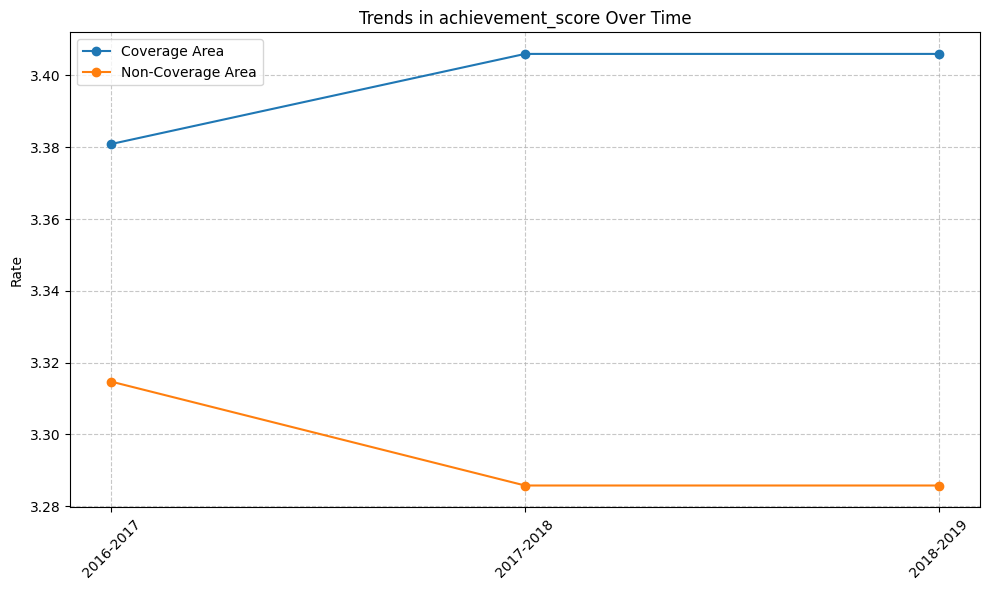


Changes in achievement_score:

Coverage Area:
2016-2017: 3.381
2018-2019: 3.406
Change: 0.025

Non-Coverage Area:
2016-2017: 3.315
2018-2019: 3.286
Change: -0.029



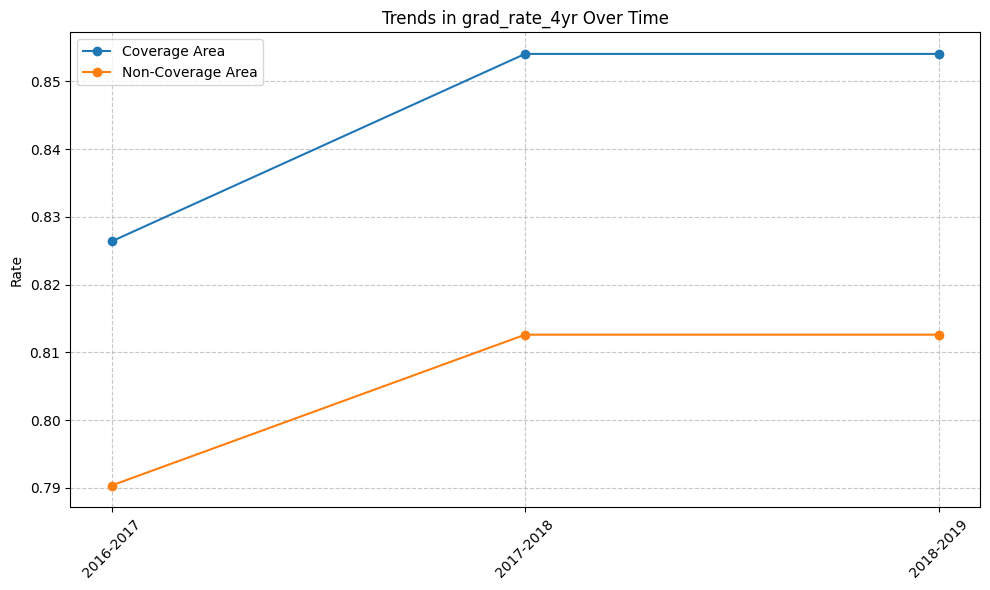


Changes in grad_rate_4yr:

Coverage Area:
2016-2017: 0.826
2018-2019: 0.854
Change: 0.028

Non-Coverage Area:
2016-2017: 0.790
2018-2019: 0.813
Change: 0.022



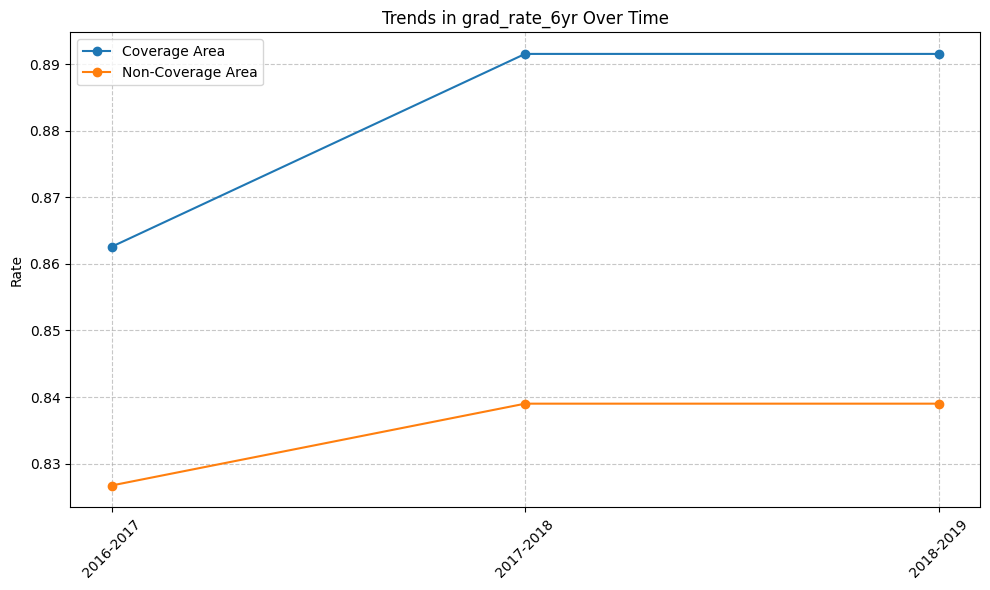


Changes in grad_rate_6yr:

Coverage Area:
2016-2017: 0.863
2018-2019: 0.892
Change: 0.029

Non-Coverage Area:
2016-2017: 0.827
2018-2019: 0.839
Change: 0.012



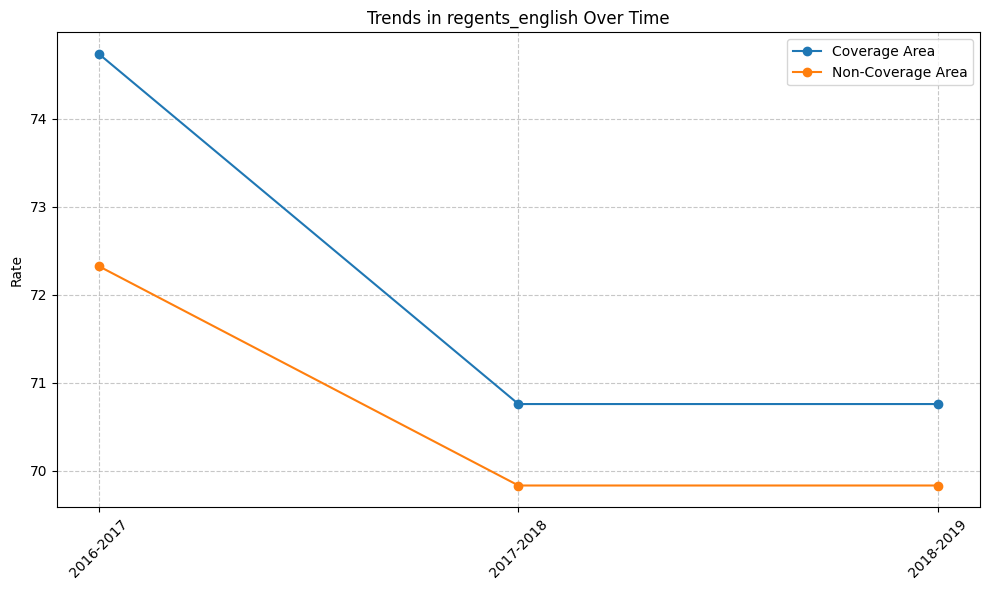


Changes in regents_english:

Coverage Area:
2016-2017: 74.736
2018-2019: 70.760
Change: -3.976

Non-Coverage Area:
2016-2017: 72.325
2018-2019: 69.835
Change: -2.490



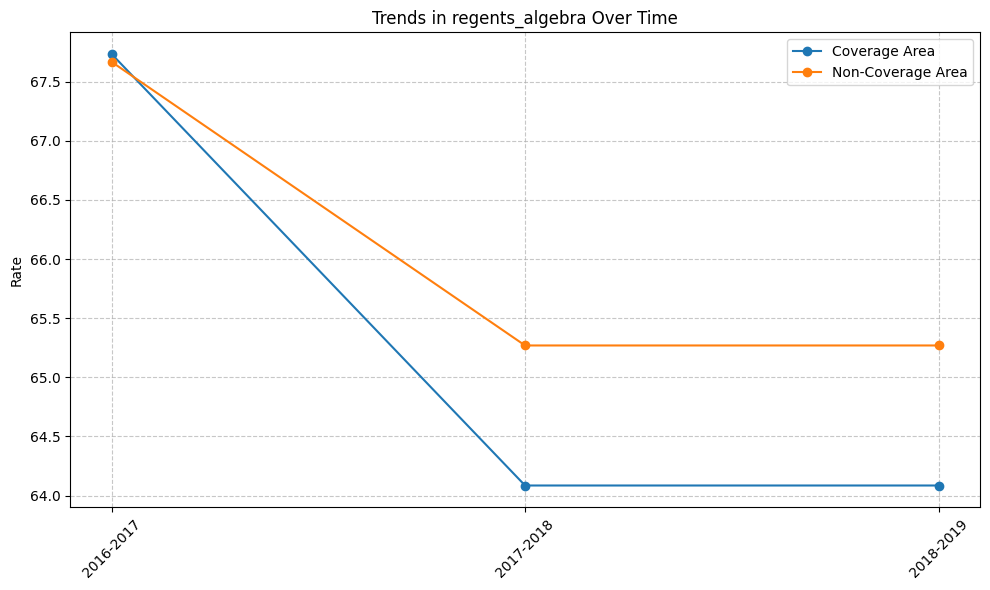


Changes in regents_algebra:

Coverage Area:
2016-2017: 67.735
2018-2019: 64.085
Change: -3.650

Non-Coverage Area:
2016-2017: 67.668
2018-2019: 65.269
Change: -2.399



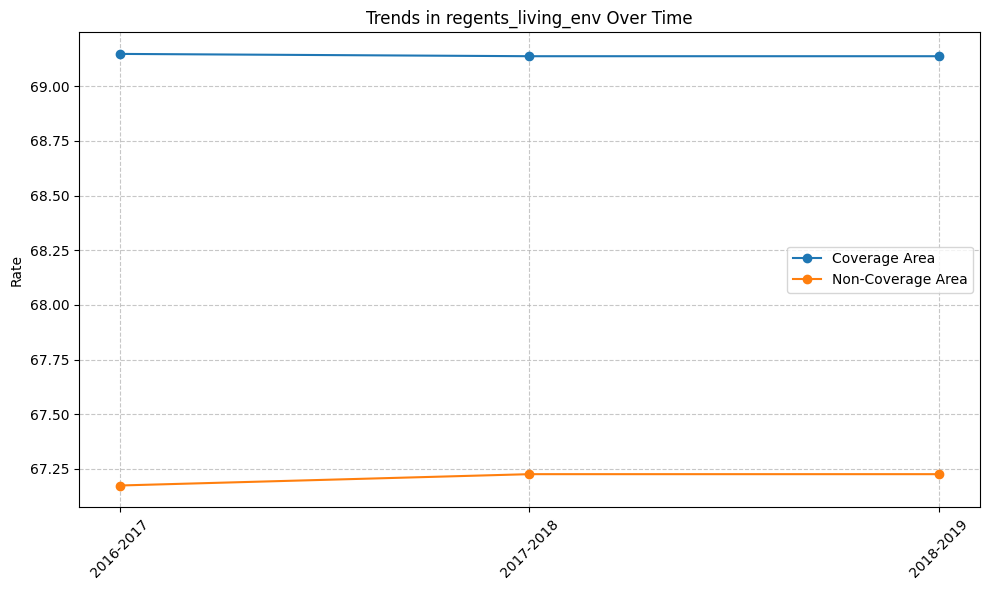


Changes in regents_living_env:

Coverage Area:
2016-2017: 69.147
2018-2019: 69.137
Change: -0.011

Non-Coverage Area:
2016-2017: 67.174
2018-2019: 67.226
Change: 0.052



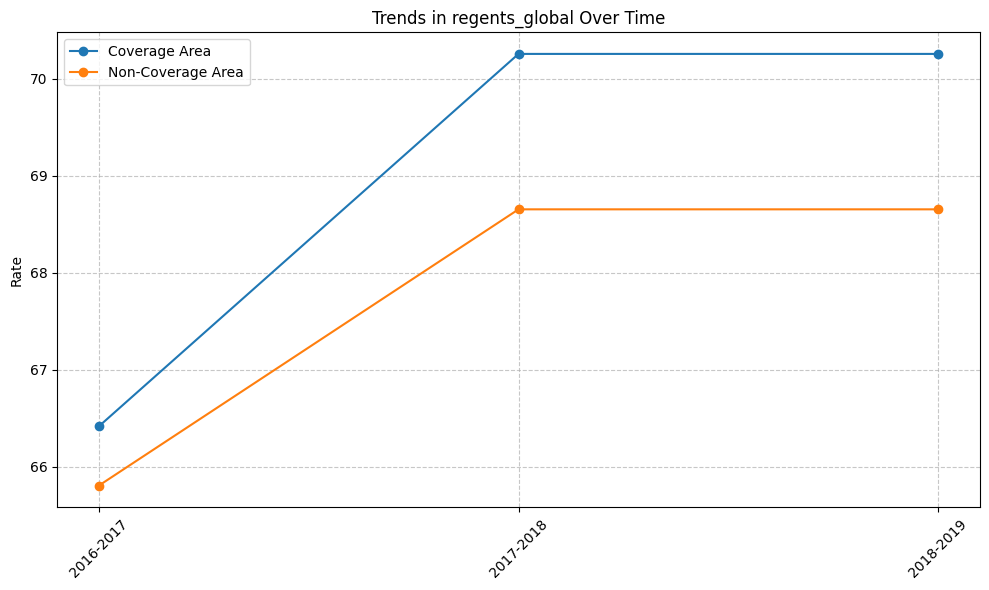


Changes in regents_global:

Coverage Area:
2016-2017: 66.417
2018-2019: 70.256
Change: 3.839

Non-Coverage Area:
2016-2017: 65.805
2018-2019: 68.653
Change: 2.848



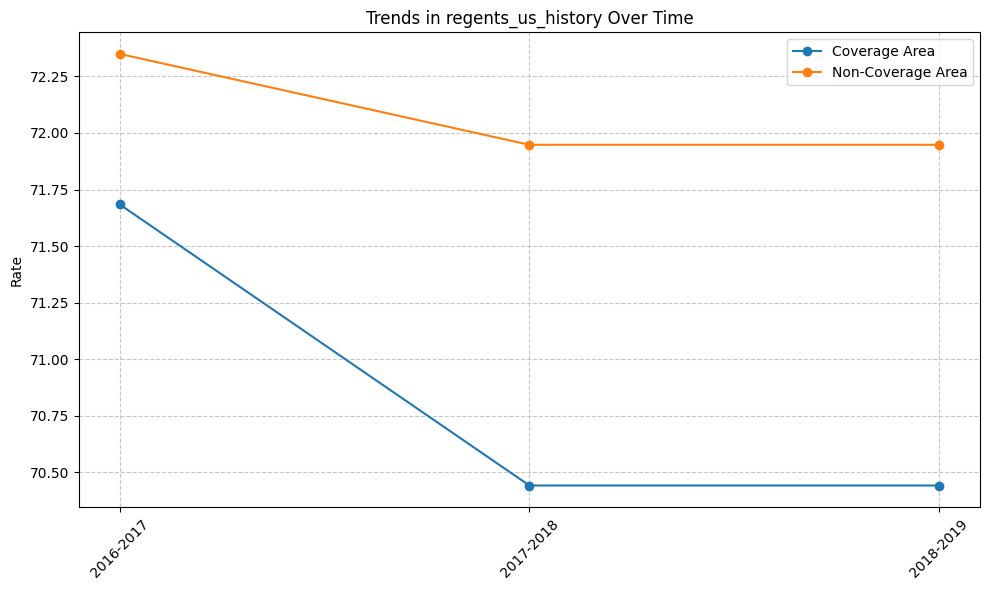


Changes in regents_us_history:

Coverage Area:
2016-2017: 71.684
2018-2019: 70.442
Change: -1.242

Non-Coverage Area:
2016-2017: 72.350
2018-2019: 71.948
Change: -0.402



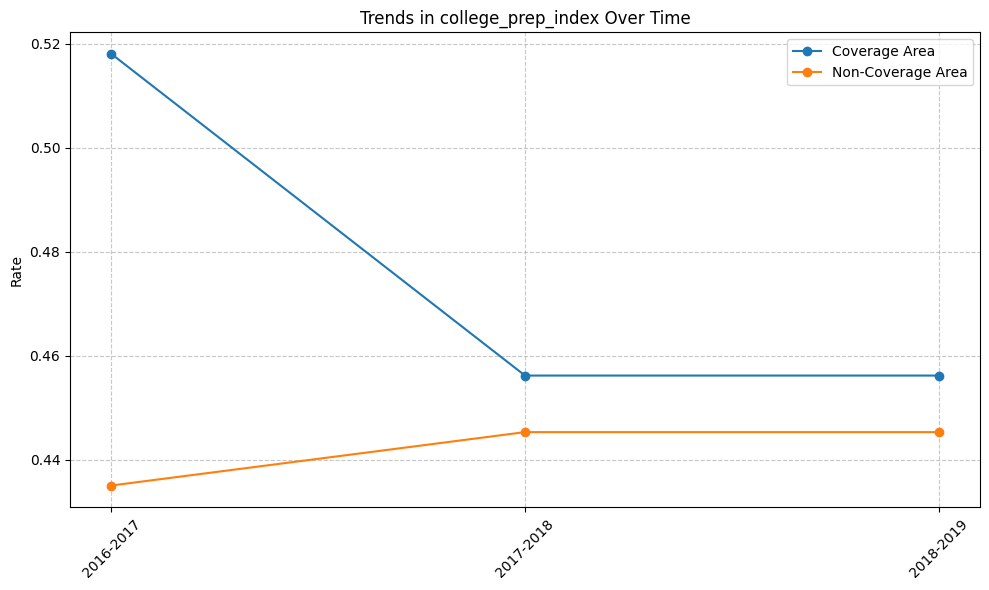


Changes in college_prep_index:

Coverage Area:
2016-2017: 0.518
2018-2019: 0.456
Change: -0.062

Non-Coverage Area:
2016-2017: 0.435
2018-2019: 0.445
Change: 0.010



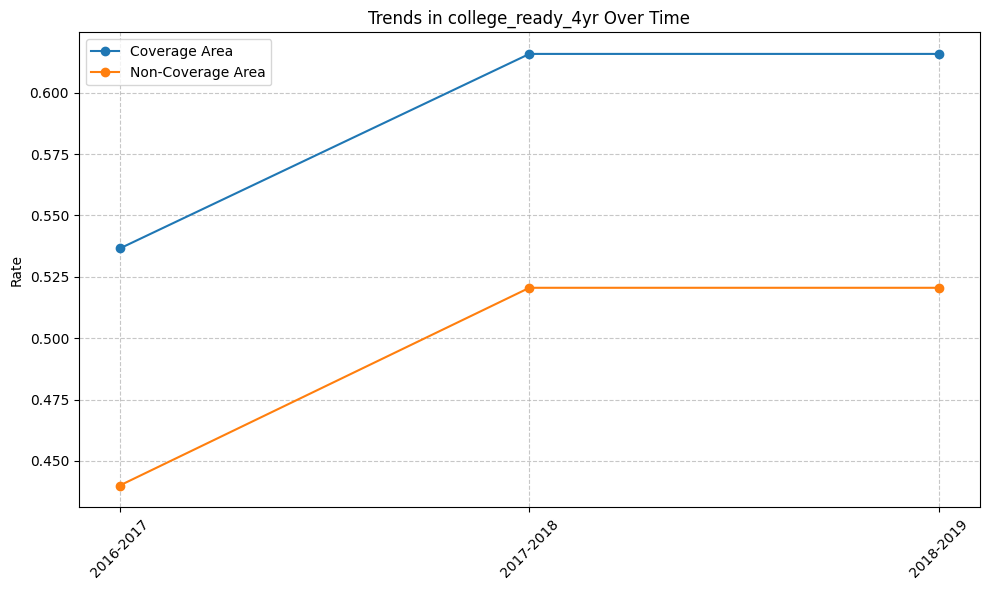


Changes in college_ready_4yr:

Coverage Area:
2016-2017: 0.537
2018-2019: 0.616
Change: 0.079

Non-Coverage Area:
2016-2017: 0.440
2018-2019: 0.521
Change: 0.081



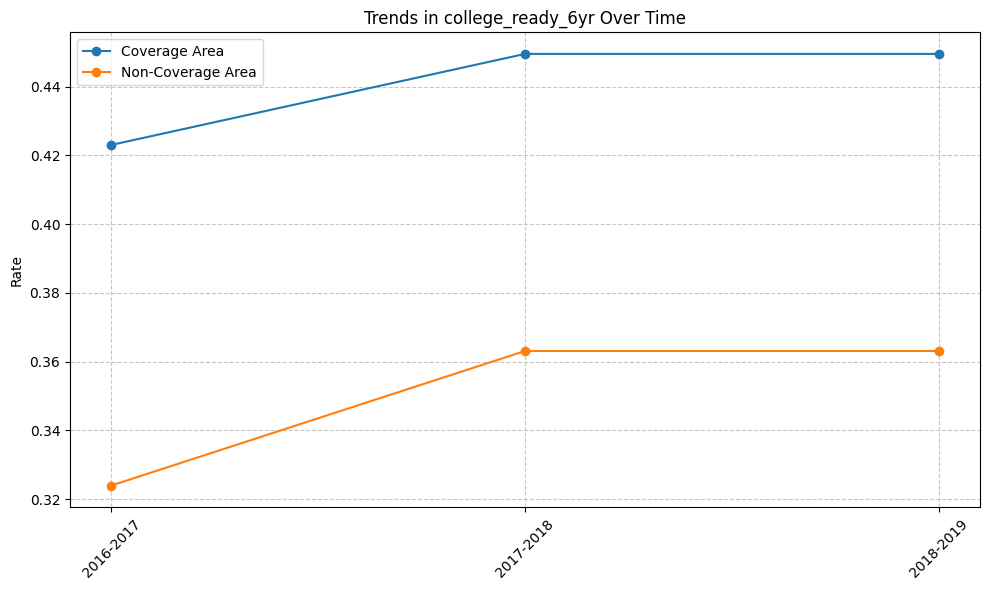


Changes in college_ready_6yr:

Coverage Area:
2016-2017: 0.423
2018-2019: 0.450
Change: 0.026

Non-Coverage Area:
2016-2017: 0.324
2018-2019: 0.363
Change: 0.039



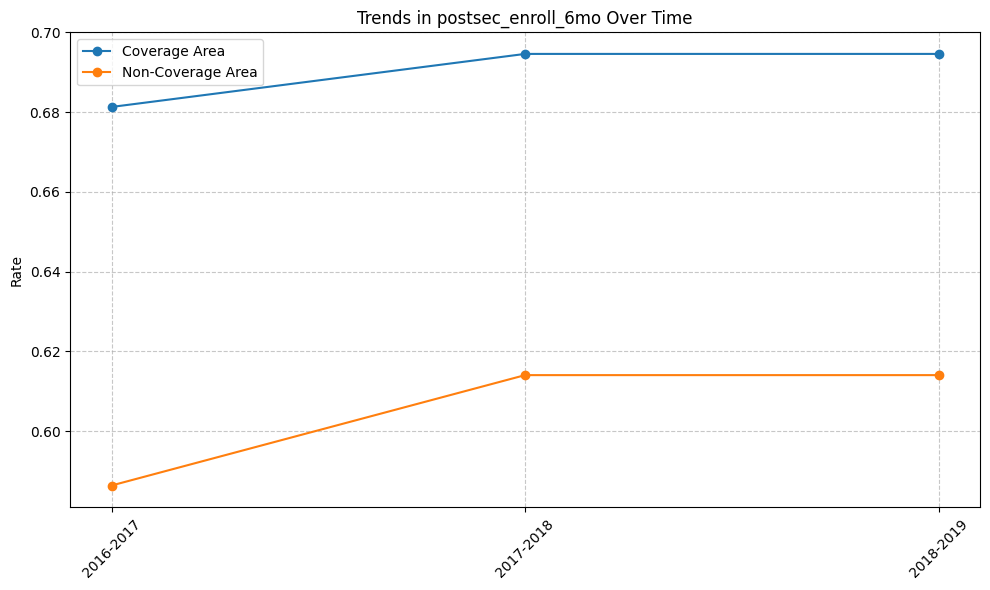


Changes in postsec_enroll_6mo:

Coverage Area:
2016-2017: 0.681
2018-2019: 0.695
Change: 0.013

Non-Coverage Area:
2016-2017: 0.586
2018-2019: 0.614
Change: 0.028



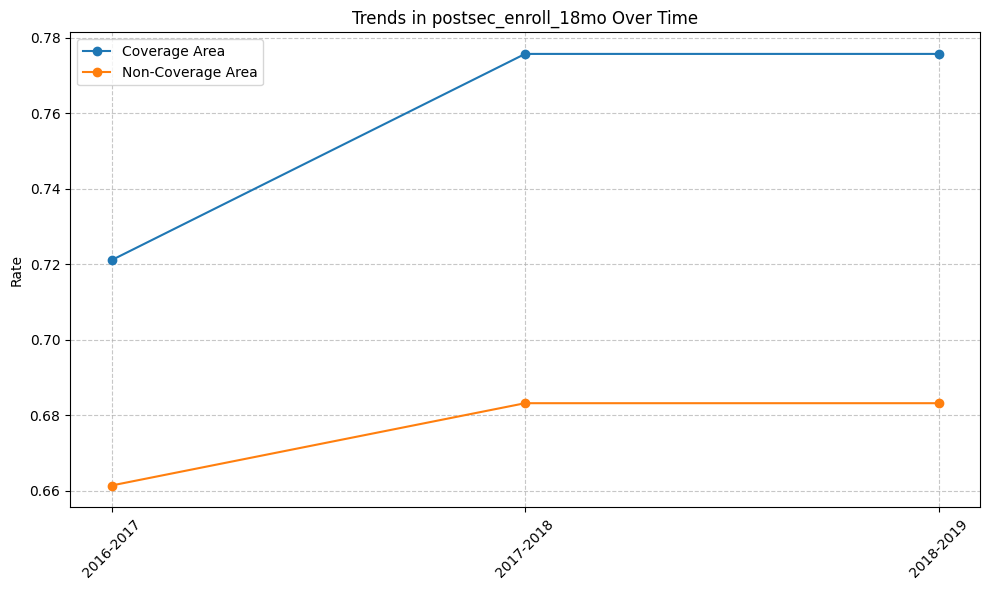


Changes in postsec_enroll_18mo:

Coverage Area:
2016-2017: 0.721
2018-2019: 0.776
Change: 0.055

Non-Coverage Area:
2016-2017: 0.661
2018-2019: 0.683
Change: 0.022



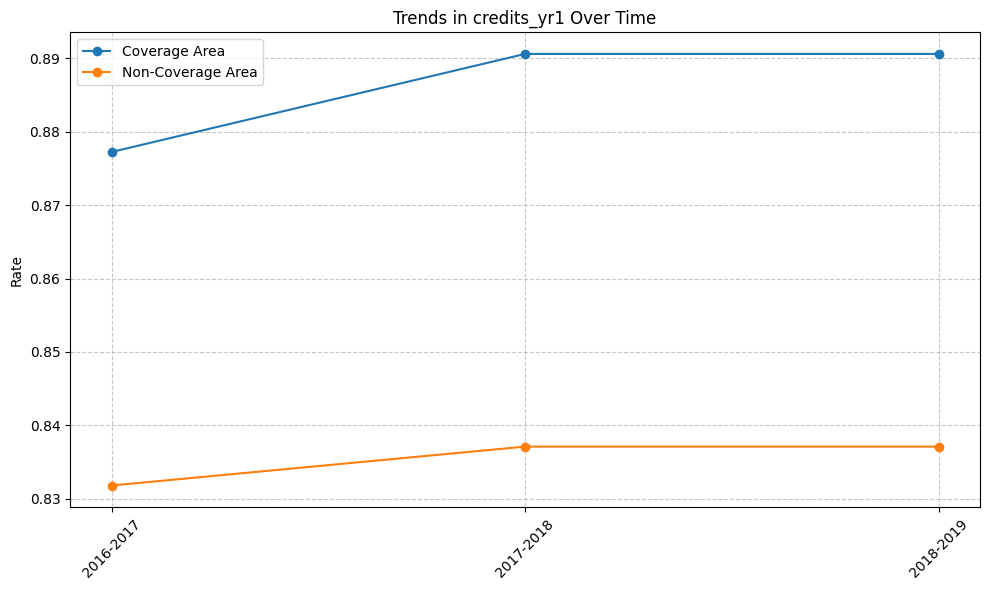


Changes in credits_yr1:

Coverage Area:
2016-2017: 0.877
2018-2019: 0.891
Change: 0.013

Non-Coverage Area:
2016-2017: 0.832
2018-2019: 0.837
Change: 0.005



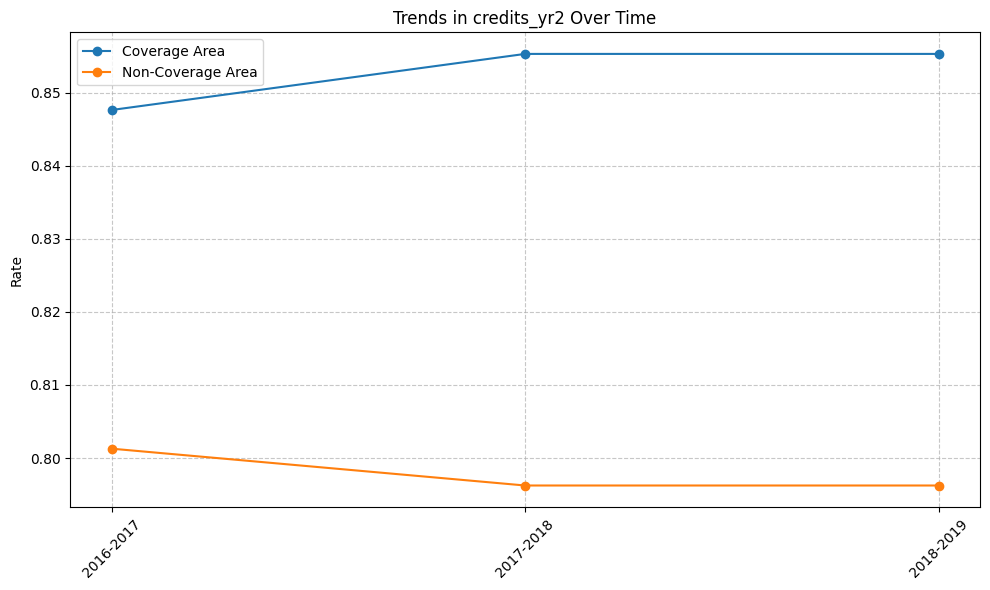


Changes in credits_yr2:

Coverage Area:
2016-2017: 0.848
2018-2019: 0.855
Change: 0.008

Non-Coverage Area:
2016-2017: 0.801
2018-2019: 0.796
Change: -0.005



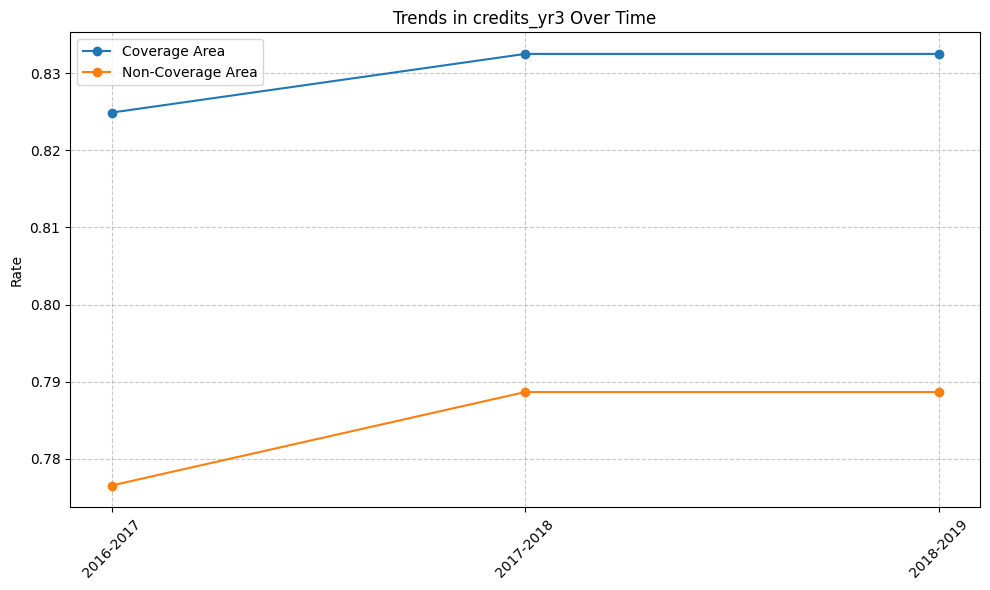


Changes in credits_yr3:

Coverage Area:
2016-2017: 0.825
2018-2019: 0.832
Change: 0.008

Non-Coverage Area:
2016-2017: 0.777
2018-2019: 0.789
Change: 0.012



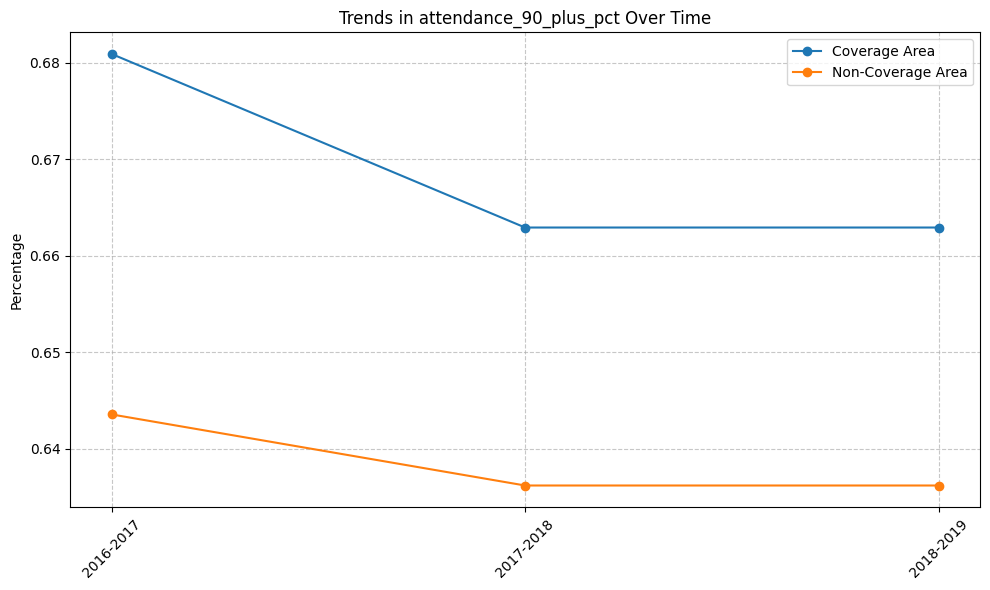


Changes in attendance_90_plus_pct:

Coverage Area:
2016-2017: 0.681
2018-2019: 0.663
Change: -0.018

Non-Coverage Area:
2016-2017: 0.644
2018-2019: 0.636
Change: -0.007



In [37]:
# Calculate means for each year and area
coverage_hs_ach_means = {
    '2016-2017': covered_hs_ach_16_17[hs_ach_features].mean(),
    '2017-2018': covered_hs_ach_17_18[hs_ach_features].mean(),
    '2018-2019': covered_hs_ach_18_19[hs_ach_features].mean()
}

non_coverage_hs_ach_means = {
    '2016-2017': non_covered_hs_ach_16_17[hs_ach_features].mean(),
    '2017-2018': non_covered_hs_ach_17_18[hs_ach_features].mean(),
    '2018-2019': non_covered_hs_ach_18_19[hs_ach_features].mean()
}

# Create DataFrames for easier plotting
coverage_hs_ach_trends = pd.DataFrame(coverage_hs_ach_means)
non_coverage_hs_ach_trends = pd.DataFrame(non_coverage_hs_ach_means)

# Plot trends for each demographic feature
for feature in hs_ach_features:
    plt.figure(figsize=(10, 6))
    
    # Plot both coverage and non-coverage trends
    plt.plot(coverage_hs_ach_trends.columns, coverage_hs_ach_trends.loc[feature], 
             marker='o', label='Coverage Area')
    plt.plot(non_coverage_hs_ach_trends.columns, non_coverage_hs_ach_trends.loc[feature], 
             marker='o', label='Non-Coverage Area')
    
    plt.title(f'Trends in {feature} Over Time')
    plt.ylabel('Percentage' if 'pct' in feature else 'Rate')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Print numeric changes
    print(f"\nChanges in {feature}:")
    print("\nCoverage Area:")
    print(f"2016-2017: {coverage_hs_ach_trends.loc[feature, '2016-2017']:.3f}")
    print(f"2018-2019: {coverage_hs_ach_trends.loc[feature, '2018-2019']:.3f}")
    print(f"Change: {coverage_hs_ach_trends.loc[feature, '2018-2019'] - coverage_hs_ach_trends.loc[feature, '2016-2017']:.3f}")
    
    print("\nNon-Coverage Area:")
    print(f"2016-2017: {non_coverage_hs_ach_trends.loc[feature, '2016-2017']:.3f}")
    print(f"2018-2019: {non_coverage_hs_ach_trends.loc[feature, '2018-2019']:.3f}")
    print(f"Change: {non_coverage_hs_ach_trends.loc[feature, '2018-2019'] - non_coverage_hs_ach_trends.loc[feature, '2016-2017']:.3f}")
    
    print("\n" + "="*50)

**Summary of high school achievement metrics:**<br>
With a few exceptions, trends for both coverage and non-coverage schools seem to follow the same pattern. There is a slight gap between coverage and non-coverage schools for all variables.

---

## School noise coefficient of variation <a name="coefficient-variation"></a>
How much does noise exposure vary over time for each school? To answer this question, we can look at the coefficient of variation per noise, per school. We will create a dataframe, `cv`, that contains this information.

In [38]:
# Check year-to-year variation
yearly_stats = school_patterns_df.groupby(['academic_year', 'DBN'])[presence_cols].mean()

# Calculate coefficient of variation for each school across years
cv = yearly_stats.groupby('DBN').std() / yearly_stats.groupby('DBN').mean()

In [39]:
# Look at distribution of variation
cv.describe()

,1_engine_presence,2_machinery-impact_presence,3_non-machinery-impact_presence,4_powered-saw_presence,5_alert-signal_presence,6_music_presence,7_human-voice_presence,8_dog_presence
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,0.088818,0.386273,0.220587,0.488690,0.223126,0.413144,0.155105,0.817644
std,0.053529,0.211238,0.158049,0.373288,0.131968,0.301765,0.159178,0.504588
min,0.010986,0.089547,0.030006,0.095571,0.049392,0.075364,0.021944,0.086312
25%,0.058689,0.166991,0.125870,0.177966,0.088171,0.249658,0.048766,0.240256
50%,0.064549,0.458545,0.221198,0.450875,0.209136,0.331383,0.102550,0.999311
75%,0.136724,0.565685,0.262273,0.552709,0.327335,0.493509,0.167990,1.129459
max,0.266650,0.784964,0.835816,1.186639,0.640348,1.414214,0.718402,1.732051


In [40]:
cv

,1_engine_presence,2_machinery-impact_presence,3_non-machinery-impact_presence,4_powered-saw_presence,5_alert-signal_presence,6_music_presence,7_human-voice_presence,8_dog_presence
DBN,,,,,,,,
01M063,0.044435,0.189577,0.325939,0.197414,0.185481,0.146996,0.198104,0.884993
01M315,0.075975,0.606390,0.198281,0.452619,0.211071,0.177632,0.327244,0.400603
01M363,0.044435,0.189577,0.325939,0.197414,0.185481,0.146996,0.198104,0.884993
01M450,0.158367,0.784964,0.125870,0.272908,0.379767,0.331383,0.102550,0.999311
02M003,0.066196,0.379460,0.182404,0.433560,0.049392,0.235084,0.082290,1.144689
02M006,0.115080,0.089547,0.138940,0.095571,0.084692,0.075364,0.239521,0.852418
02M041,0.066601,0.178698,0.184806,0.255105,0.189798,0.222893,0.036021,0.172932
02M130,0.059219,0.273753,0.099387,0.212441,0.127653,0.201032,0.172809,1.110295
02M135,0.064549,0.565685,0.249567,1.186639,0.348710,0.514259,0.048766,1.414214


The high CV for some schools suggests that year-to-year variation in sound levels could have a significant impact on academic achievement.

### Noise and school performance variations <a name="noise-performance"></a>
How much does school achievement vary based on noise exposure? Which sounds are most strongly associated with variation in school achievement? We can calculate the coefficient of variation per school, per achievement metric to see how strongly variations in achievement scores correlate with the presence of different types of noise.


Lower Grades - Correlations between noise and performance variations:
                                 ela_proficient_pct_cv  \
1_engine_presence                             0.597232   
2_machinery-impact_presence                   0.641058   
3_non-machinery-impact_presence              -0.116177   
4_powered-saw_presence                        0.303990   
5_alert-signal_presence                       0.504182   
6_music_presence                              0.392982   
7_human-voice_presence                        0.370422   
8_dog_presence                                0.365460   

                                 math_proficient_pct_cv  \
1_engine_presence                              0.561413   
2_machinery-impact_presence                    0.481270   
3_non-machinery-impact_presence                0.491383   
4_powered-saw_presence                         0.059864   
5_alert-signal_presence                        0.526757   
6_music_presence                               0.306

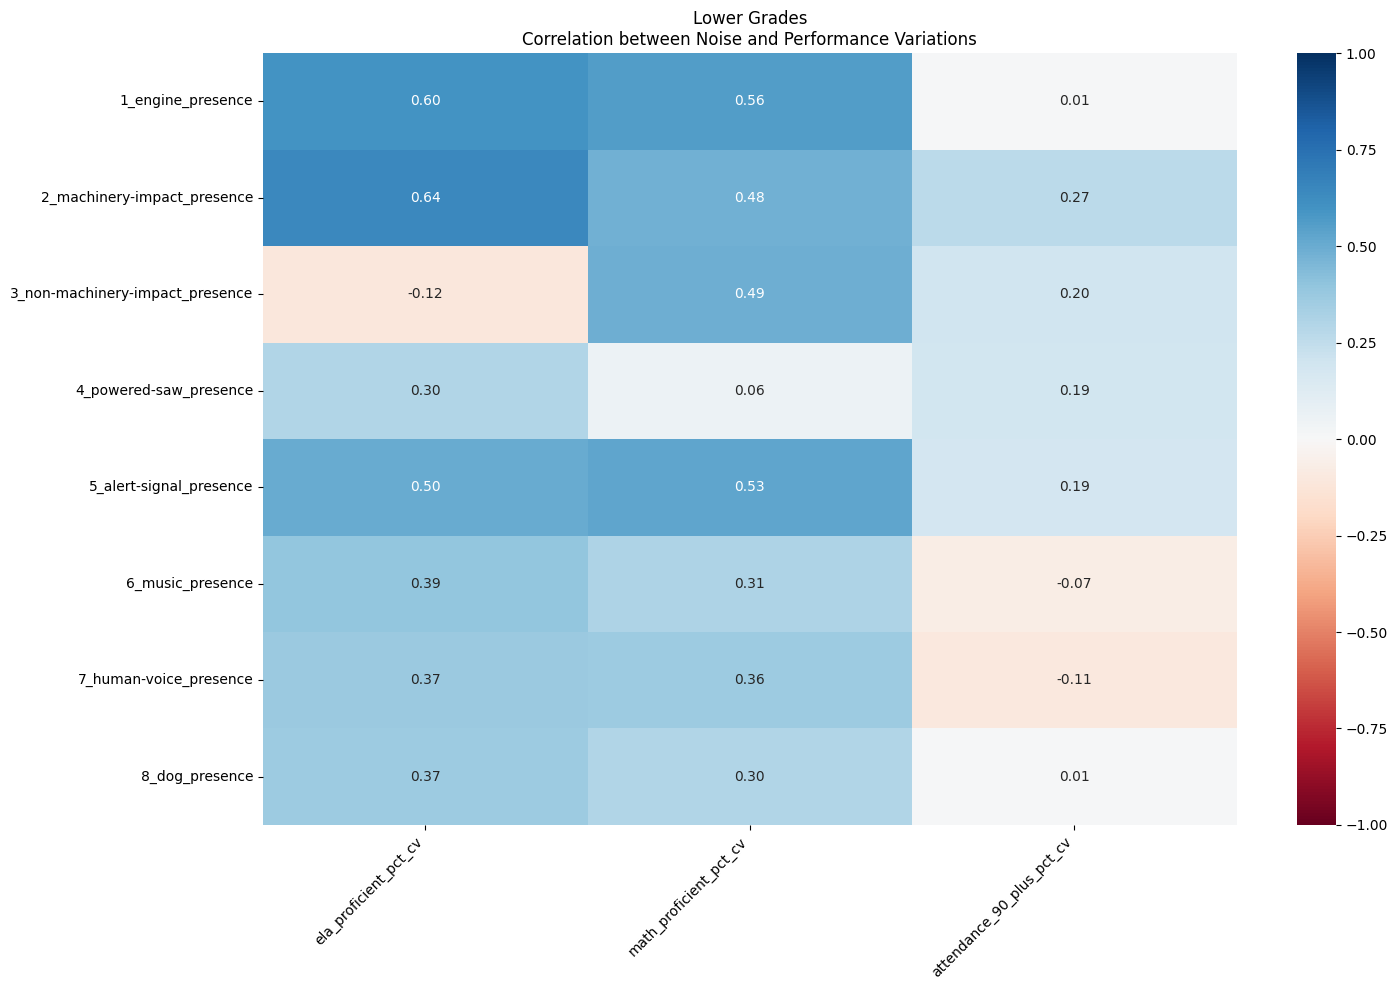


High Schools - Correlations between noise and performance variations:
                                 regents_english_cv  regents_algebra_cv  \
1_engine_presence                         -0.102515           -0.105089   
2_machinery-impact_presence                0.115294           -0.089770   
3_non-machinery-impact_presence           -0.106768           -0.113161   
4_powered-saw_presence                     0.282582           -0.055279   
5_alert-signal_presence                    0.198055           -0.120468   
6_music_presence                          -0.031649           -0.080014   
7_human-voice_presence                    -0.269838           -0.109743   
8_dog_presence                             0.192477           -0.099781   

                                 attendance_90_plus_pct_cv  
1_engine_presence                                 0.160003  
2_machinery-impact_presence                       0.188003  
3_non-machinery-impact_presence                   0.057409  
4_powered

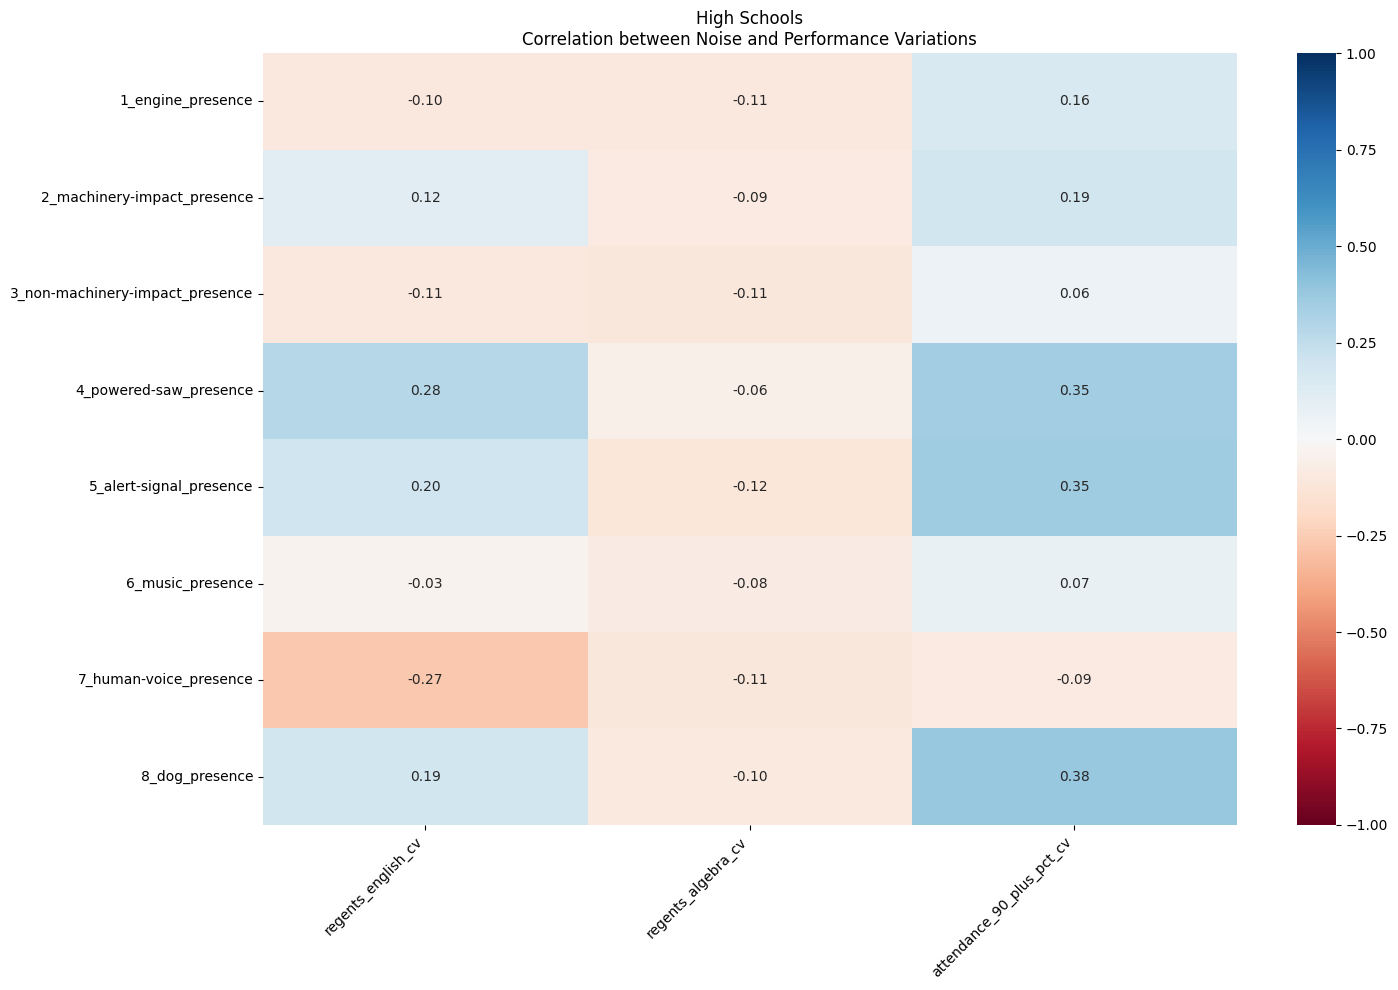


Summary of variations:

Lower Grades Performance CV:
       ela_proficient_pct_cv  math_proficient_pct_cv  \
count            1282.000000             1280.000000   
mean                0.109388                0.116718   
std                 0.100480                0.124135   
min                 0.000000                0.000000   
25%                 0.044989                0.033294   
50%                 0.086084                0.077213   
75%                 0.147048                0.161973   
max                 1.732051                1.732051   

       attendance_90_plus_pct_cv  
count                1253.000000  
mean                    0.026474  
std                     0.028235  
min                     0.000000  
25%                     0.007288  
50%                     0.017806  
75%                     0.035712  
max                     0.245181  

High Schools Performance CV:
       regents_english_cv  regents_algebra_cv  attendance_90_plus_pct_cv
count          479.0000

In [41]:
# First, calculate year-to-year changes for lower grades
lg_yearly_changes = (combined_lg_achievement_df
    .groupby('DBN')
    .agg({
        'ela_proficient_pct': ['std', 'mean'],
        'math_proficient_pct': ['std', 'mean'],
        'attendance_90_plus_pct': ['std', 'mean']
    })
)

# Calculate CV for achievement metrics
lg_cv = pd.DataFrame()
for metric in ['ela_proficient_pct', 'math_proficient_pct', 'attendance_90_plus_pct']:
    lg_cv[f"{metric}_cv"] = lg_yearly_changes[(metric, 'std')] / lg_yearly_changes[(metric, 'mean')]

# Same for high schools
hs_yearly_changes = (combined_hs_achievement_df
    .groupby('DBN')
    .agg({
        'regents_english': ['std', 'mean'],
        'regents_algebra': ['std', 'mean'],
        'attendance_90_plus_pct': ['std', 'mean']
    })
)

# Calculate CV for achievement metrics
hs_cv = pd.DataFrame()
for metric in ['regents_english', 'regents_algebra', 'attendance_90_plus_pct']:
    hs_cv[f"{metric}_cv"] = hs_yearly_changes[(metric, 'std')] / hs_yearly_changes[(metric, 'mean')]

# Merge with noise CVs
lg_comparison = pd.merge(cv, lg_cv, left_index=True, right_index=True)
hs_comparison = pd.merge(cv, hs_cv, left_index=True, right_index=True)

def print_correlations(comparison_df, title):
    # Get noise columns
    noise_cols = [col for col in comparison_df.columns if 'presence' in col]
    # Get performance columns
    perf_cols = [col for col in comparison_df.columns if col not in noise_cols]
    
    # Print correlations
    print(f"\n{title} - Correlations between noise and performance variations:")
    corr_matrix = comparison_df[noise_cols + perf_cols].corr()
    print(corr_matrix.loc[noise_cols, perf_cols])
    
    # Create heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        corr_matrix.loc[noise_cols, perf_cols],
        annot=True,
        cmap='RdBu',
        center=0,
        vmin=-1,
        vmax=1,
        fmt='.2f'
    )
    plt.title(f"{title}\nCorrelation between Noise and Performance Variations")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Print correlation analysis for both school types
if not lg_comparison.empty:
    print_correlations(lg_comparison, "Lower Grades")
if not hs_comparison.empty:
    print_correlations(hs_comparison, "High Schools")

# Print summary statistics for CVs
print("\nSummary of variations:")
print("\nLower Grades Performance CV:")
print(lg_cv.describe())
print("\nHigh Schools Performance CV:")
print(hs_cv.describe())

We have uncovered some interesting relationships between noise variation and school performance.

Key insights include:
1. Lower grades show stronger noise-performance relationships than high schools.
2. ELA and Math proficiency variations are more strongly related to noise variations than attendance.
3. Mechanical noises (engine, machinery) show stronger correlations than human-generated sounds.
4. High schools seem more resilient to noise variation in terms of academic performance.

---

## Analysis of noise impact on academic achievement <a name="noise-achievement-impact"></a>
Are certain noises more impactful to student achievement than others? To investigate this question, we will create a correlation heatmap showing how strongly certain student achievement metrics are correlated with different categories of noise.

In our last section, we learned that lower grades show stronger noise-performance relationships than high schools, indicating that lower grades might be more sensitive to noise variation. Because lower grades are differently affected by sound than high schoolers, we will maintain separation between these two grade levels throughout the rest of our exploratory data analysis.

In this section, we will look at achievement metrics for English, math, and attendance for both lower grades and high school. 
- For lower grades, we will use `ela_proficient_pct` and `math_proficient_pct`&mdash; the percentage of students who have scored at least "Proficient" on New York State tests for English Language Arts and Mathematics, respectively. These tests are taken each spring for 3rd through 8th graders. 
- For high school grades, we will look at the percentage of students who have scored at least at "target level" &mdash; a customized score set for each school by the State of New York to ensure schools are performing up to standard - in the New York State Regents exams for English and Algebra. These are `regents_english` and `regents_algebra`, respectively.

In [42]:
# Prepare noise data (using mean levels for each school)
noise_cols = [col for col in school_patterns_df.columns if 'presence' in col]
school_noise = school_patterns_df.groupby('DBN')[noise_cols].mean().reset_index()

# Merge with lower grades achievement data
lg_analysis = (combined_lg_achievement_df
    .merge(school_noise, on='DBN', how='inner')
)

# Merge with high school achievement data
hs_analysis = (combined_hs_achievement_df
    .merge(school_noise, on='DBN', how='inner')
)

# Function to create correlation heatmap
def plot_achievement_correlations(data, achievement_cols, title):
    plt.figure(figsize=(12, 8))
    
    # Calculate correlations between noise and achievement
    corr_matrix = data[noise_cols + achievement_cols].corr()
    corr_subset = corr_matrix.loc[noise_cols, achievement_cols]
    
    # Create heatmap
    sns.heatmap(corr_subset, 
                annot=True, 
                cmap='RdBu', 
                center=0,
                vmin=-1, 
                vmax=1,
                fmt='.2f')
    
    plt.title(title, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print strongest correlations
    print(f"\nTop correlations for {title}:")
    for achievement in achievement_cols:
        correlations = corr_subset[achievement].sort_values(ascending=False)
        print(f"\nStrongest correlations with {achievement}:")
        print(correlations.head(3))

### Noise-Achievement correlations: Lower grades <a name="lg-correlations"></a>

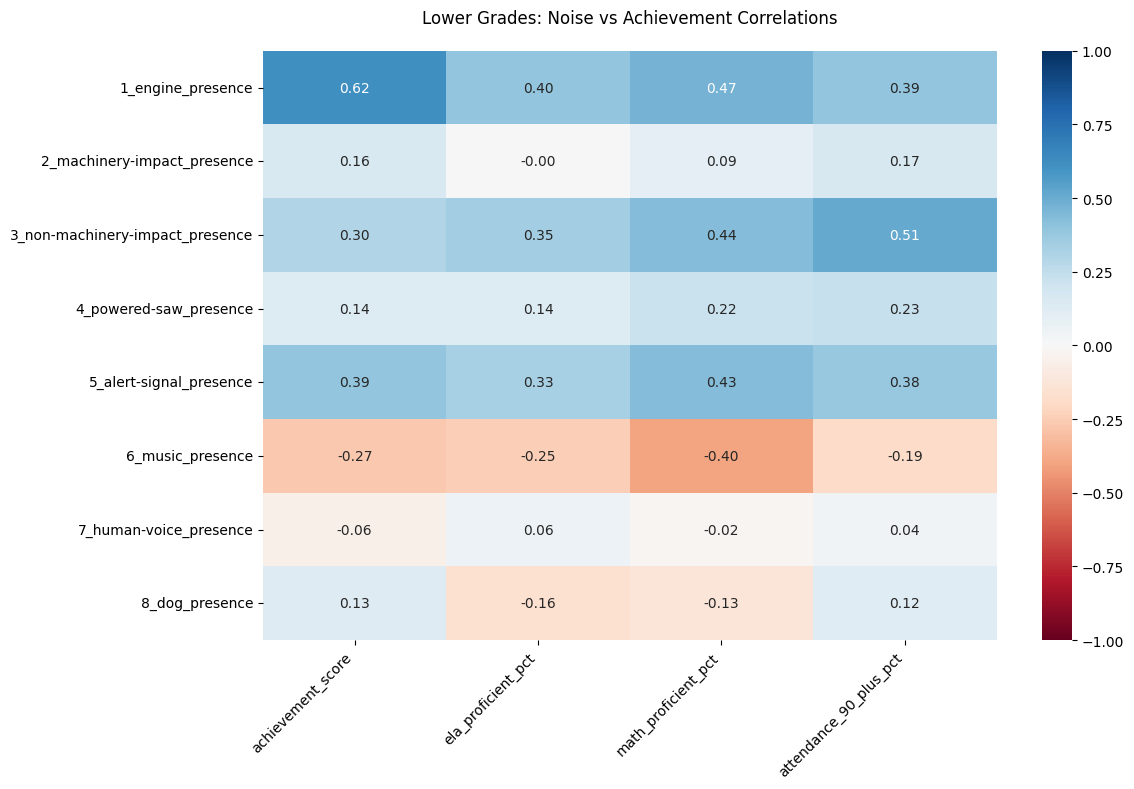


Top correlations for Lower Grades: Noise vs Achievement Correlations:

Strongest correlations with achievement_score:
1_engine_presence                  0.616531
5_alert-signal_presence            0.394541
3_non-machinery-impact_presence    0.298658
Name: achievement_score, dtype: float64

Strongest correlations with ela_proficient_pct:
1_engine_presence                  0.395700
3_non-machinery-impact_presence    0.345350
5_alert-signal_presence            0.328795
Name: ela_proficient_pct, dtype: float64

Strongest correlations with math_proficient_pct:
1_engine_presence                  0.473393
3_non-machinery-impact_presence    0.437227
5_alert-signal_presence            0.432669
Name: math_proficient_pct, dtype: float64

Strongest correlations with attendance_90_plus_pct:
3_non-machinery-impact_presence    0.514486
1_engine_presence                  0.393052
5_alert-signal_presence            0.380484
Name: attendance_90_plus_pct, dtype: float64


In [43]:
# Lower Grades Analysis
lg_achievement_cols = [
    'achievement_score',
    'ela_proficient_pct',
    'math_proficient_pct',
    'attendance_90_plus_pct'
]

# Create correlation heatmap
plt.figure(figsize=(12, 8))
    
# Calculate correlations between noise and achievement
corr_matrix = lg_analysis[noise_cols + lg_achievement_cols].corr()
corr_subset = corr_matrix.loc[noise_cols, lg_achievement_cols]
    
# Create heatmap
sns.heatmap(corr_subset, 
            annot=True, 
            cmap='RdBu', 
            center=0,
            vmin=-1, 
            vmax=1,
            fmt='.2f')

plt.title('Lower Grades: Noise vs Achievement Correlations', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the figure to a file
plt.savefig("./Figures/lg_noise_vs_achievement_corr_heatmap.png", dpi=300, bbox_inches='tight')

plt.show()
    
# Print strongest correlations
print(f"\nTop correlations for Lower Grades: Noise vs Achievement Correlations:")
for achievement in lg_achievement_cols:
    correlations = corr_subset[achievement].sort_values(ascending=False)
    print(f"\nStrongest correlations with {achievement}:")
    print(correlations.head(3))

**Observations:**<br>
Interestingly, our correlation map suggests that certain noises are positively correlated with some student achievement metrics. Engine presence has a strong positive correlation with achievement score, which could suggest that schools in busier, more urban areas have better access to resources that enable student success.

Engine, non-machinery, and alert signal noises are positively correlated with ELA and Math proficiency, as well as high attendance.

However, music is very strongly negatively correlated with math proficiency. It is also negatively correlated with ELA proficiency and 90%+ attendance rates, although to a lesser degree.

### Noise-Achievement correlations: High school <a name="hs-correlations"></a>

In [44]:
hs_analysis.columns

Index(['DBN', 'school_name', 'school_type', 'achievement_score',
       'grad_rate_4yr', 'grad_rate_6yr', 'regents_english', 'regents_algebra',
       'regents_living_env', 'regents_global', 'regents_us_history',
       'college_prep_index', 'college_ready_4yr', 'college_ready_6yr',
       'postsec_enroll_6mo', 'postsec_enroll_18mo', 'credits_yr1',
       'credits_yr2', 'credits_yr3', 'grad_rate_n', 'regents_english_n',
       'college_ready_n', 'attendance_90_plus_pct', 'academic_year',
       'coverage', 'grade_level', '1_engine_presence',
       '2_machinery-impact_presence', '3_non-machinery-impact_presence',
       '4_powered-saw_presence', '5_alert-signal_presence', '6_music_presence',
       '7_human-voice_presence', '8_dog_presence'],
      dtype='object')

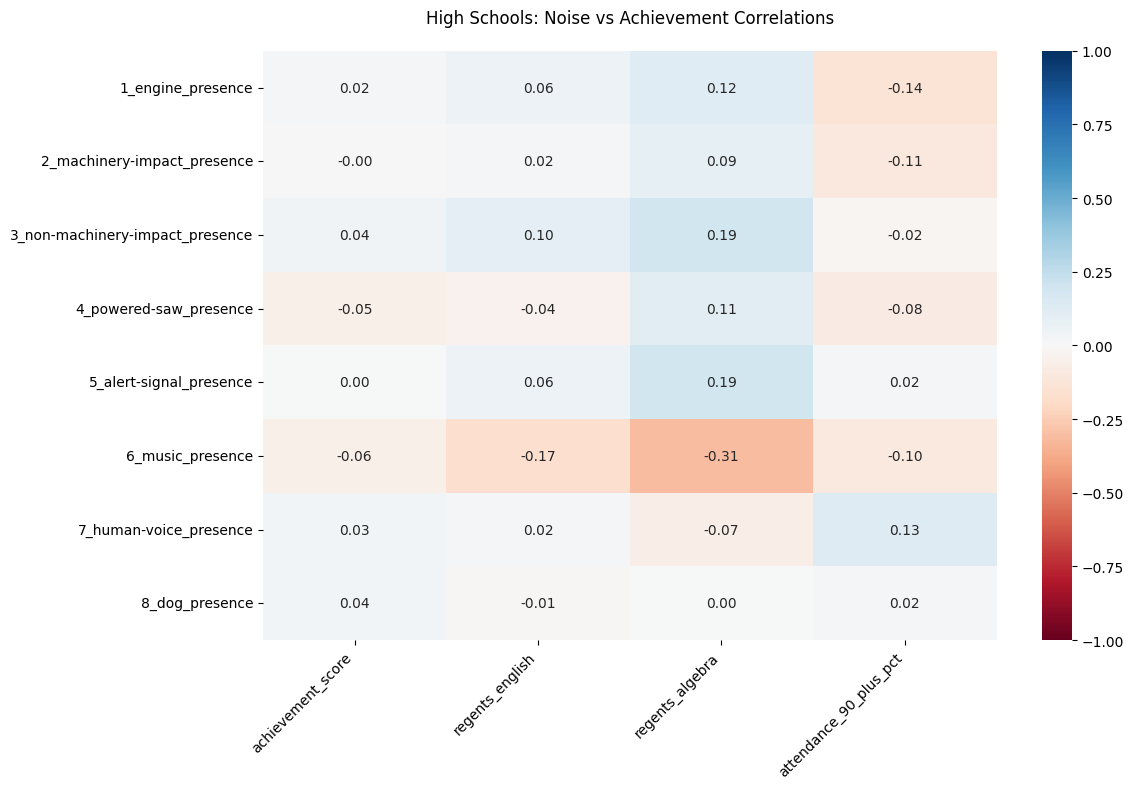


Top correlations for High Schools: Noise vs Achievement Correlations:

Strongest correlations with achievement_score:
3_non-machinery-impact_presence    0.043426
8_dog_presence                     0.037738
7_human-voice_presence             0.031617
Name: achievement_score, dtype: float64

Strongest correlations with regents_english:
3_non-machinery-impact_presence    0.096487
5_alert-signal_presence            0.062003
1_engine_presence                  0.058774
Name: regents_english, dtype: float64

Strongest correlations with regents_algebra:
5_alert-signal_presence            0.193367
3_non-machinery-impact_presence    0.190906
1_engine_presence                  0.120998
Name: regents_algebra, dtype: float64

Strongest correlations with attendance_90_plus_pct:
7_human-voice_presence     0.126749
8_dog_presence             0.020549
5_alert-signal_presence    0.019567
Name: attendance_90_plus_pct, dtype: float64


In [45]:
# High School Analysis

hs_achievement_cols = [
    'achievement_score',
    'regents_english',
    'regents_algebra',
    'attendance_90_plus_pct'
]

# Create correlation heatmap
plt.figure(figsize=(12, 8))
    
# Calculate correlations between noise and achievement
corr_matrix = hs_analysis[noise_cols + hs_achievement_cols].corr()
corr_subset = corr_matrix.loc[noise_cols, hs_achievement_cols]
    
# Create heatmap
sns.heatmap(corr_subset, 
            annot=True, 
            cmap='RdBu', 
            center=0,
            vmin=-1, 
            vmax=1,
            fmt='.2f')

plt.title('High Schools: Noise vs Achievement Correlations', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the figure to a file
plt.savefig("./Figures/hs_noise_vs_achievement_corr_heatmap.png", dpi=300, bbox_inches='tight')

plt.show()
    
# Print strongest correlations
print(f"\nTop correlations for High Schools: Noise vs Achievement Correlations:")
for achievement in hs_achievement_cols:
    correlations = corr_subset[achievement].sort_values(ascending=False)
    print(f"\nStrongest correlations with {achievement}:")
    print(correlations.head(3))

**Observations:**<br>
For high schoolers, correlations of achievement with noise presence are weak across the board. This suggests that high schoolers may be less sensitive to environmental noise than their younger counterparts. Correlation with achievement score is especially weak.

However, just as we saw with lower grades, music has the strongest negative correlation to achievement metrics in mathematics &mdash; this time, with Regents scores in algebra. Music is also negatively correlated with 90%+ attendance rates, as well as Regents scores in English.

---

## Save variables for retrieval

### For EDA part 2
We are going to continue our EDA in a separate notebook, 2.5 - EDA part 2. This notebook will include an interactive map created using folium. We will store any variables that we need for retrieval in this notebook.

We will also change variable names to avoid any confusion.

In [46]:
# Geodataframes
schoolpoints_gdf_1 = schoolpoints_gdf.copy()
districts_gdf_1 = districts_gdf.copy()
sensors_gdf_1 = sensors_gdf.copy()

# Noise data and derived dataframes
noise_data_1 = noise_data.copy()
school_patterns_df_1 = school_patterns_df.copy()

# Achievement data
combined_lg_achievement_df_1 = combined_lg_achievement_df.copy()
combined_hs_achievement_df_1 = combined_hs_achievement_df.copy()

In [47]:
# Store geodataframes
%store schoolpoints_gdf_1
%store districts_gdf_1
%store sensors_gdf_1

# Store the noise data and derived dataframes
%store noise_data_1
%store school_patterns_df_1

# Store achievement data
%store combined_lg_achievement_df_1
%store combined_hs_achievement_df_1

# Store list of schools
%store filtered_schools

Stored 'schoolpoints_gdf_1' (GeoDataFrame)
Stored 'districts_gdf_1' (GeoDataFrame)
Stored 'sensors_gdf_1' (GeoDataFrame)
Stored 'noise_data_1' (DataFrame)
Stored 'school_patterns_df_1' (DataFrame)
Stored 'combined_lg_achievement_df_1' (DataFrame)
Stored 'combined_hs_achievement_df_1' (DataFrame)
Stored 'filtered_schools' (Series)


### For Data Pre-Processing & Machine Learning

In [48]:
%store school_patterns_df

Stored 'school_patterns_df' (DataFrame)
